In [1]:
import pandas as p
import math
import numpy as np
import itertools as it
from haversine import *
from haversine_script import *
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import Adam,Adamax
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from scipy.stats import spearmanr
from collections import OrderedDict 
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import json
from math import pi

from DAE_script import *

random_state = 42
dataset = 'sigfox' # choices: lorawan, sigfox, DSI, MAN

if dataset == 'lorawan':
    default_NaN = -200
    units = 'lat_lon'
    
    x_train = p.read_csv('files/lorawan/x_train.csv')
    x_val = p.read_csv('files/lorawan/x_val.csv')
    x_test = p.read_csv('files/lorawan/x_test.csv')
    y_train = p.read_csv('files/lorawan/y_train.csv')
    y_val = p.read_csv('files/lorawan/y_val.csv')
    y_test = p.read_csv('files/lorawan/y_test.csv')
    
elif dataset == 'sigfox':
    default_NaN = -200
    units = 'lat_lon'
    
    x_train = p.read_csv('files/sigfox/x_train.csv')
    x_val = p.read_csv('files/sigfox/x_val.csv')
    x_test = p.read_csv('files/sigfox/x_test.csv')
    y_train = p.read_csv('files/sigfox/y_train.csv')
    y_val = p.read_csv('files/sigfox/y_val.csv')
    y_test = p.read_csv('files/sigfox/y_test.csv')

    # skipping the index column included in these files
    x_columns = x_train.columns
    x_train = x_train[x_columns[1:]] 
    x_val = x_val[x_columns[1:]]
    x_test = x_test[x_columns[1:]]

    y_columns = y_train.columns
    y_train = y_train[y_columns[1:]]
    y_val = y_val[y_columns[1:]]
    y_test = y_test[y_columns[1:]]
    
elif dataset == 'DSI':
    default_NaN = -150
    units = 'meters'
    
    x_train = p.read_csv('files/DSI/x_train.csv')
    x_val = p.read_csv('files/DSI/x_val.csv')
    x_test = p.read_csv('files/DSI/x_test.csv')
    y_train = p.read_csv('files/DSI/y_train.csv')
    y_val = p.read_csv('files/DSI/y_val.csv')
    y_test = p.read_csv('files/DSI/y_test.csv')  
    
elif dataset == 'MAN':
    default_NaN = 0
    units = 'meters'
    
    x_train = p.read_csv('files/M/x_train.csv')
    x_val = p.read_csv('files/M/x_val.csv')
    x_test = p.read_csv('files/M/x_test.csv')
    y_train = p.read_csv('files/M/y_train.csv')
    y_val = p.read_csv('files/M/y_val.csv')
    y_test = p.read_csv('files/M/y_test.csv')
    
# replacing the arbitrary value of not received signal with the minimum value of the training set
if dataset != 'DSI':
    x_train = np.where(x_train==default_NaN, 0, x_train) 
    minimum = int(x_train.min() - 1)
    print('minimum')
    print(minimum)
    x_train = np.where(x_train==0, minimum, x_train) 
    x_val = np.where(x_val==default_NaN, minimum, x_val) 
    x_test = np.where(x_test==default_NaN, minimum, x_test) 


y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

print('OK')

Using TensorFlow backend.


minimum
-157
OK


# Splitting the training set into 2 equal size sets, for the training of M1 and M2

In [27]:
ratio = 0.5
x_train_1, x_train_2, y_train_1, y_train_2 = train_test_split(x_train, y_train, test_size=ratio, random_state=random_state)
print("x_train_1 size: ", x_train_1.shape)
print("x_train_2 size: ", x_train_2.shape)
print("x_val size: ", x_val.shape)
print("x_test size: ", x_test.shape)
print()

print("y_train_1 size: ", y_train_1.shape)
print("y_train_2 size: ", y_train_2.shape)
print("y_val size: ", y_val.shape)
print("y_test size: ", y_test.shape)

x_train_1 size:  (5031, 84)
x_train_2 size:  (5032, 84)
x_val size:  (2157, 84)
x_test size:  (2157, 84)

y_train_1 size:  (5031, 2)
y_train_2 size:  (5032, 2)
y_val size:  (2157, 2)
y_test size:  (2157, 2)


# Data Driven DAE (DD)

In [3]:
# M1: The positioning model
M1 = ExtraTreesRegressor(n_estimators=100,max_depth=60, min_samples_split=6, min_samples_leaf=1,n_jobs=2, random_state=random_state)
M1.fit(x_train_1,y_train_1)
y_M1_predict_in_train_1 = M1.predict(x_train_1)
y_M1_predict_in_train_2 = M1.predict(x_train_2)
y_M1_predict_in_val = M1.predict(x_val)
y_M1_predict_in_test = M1.predict(x_test)

# sanity check
for i in y_M1_predict_in_train_1:    
    if (not isinstance(i[1], np.float64)):
        print('Error')
        print(type(i[1]))

y_M1_error_train_1 = calculate_pairwise_error_list(y_train_1, y_M1_predict_in_train_1,units)
y_M1_error_train_2 = calculate_pairwise_error_list(y_train_2, y_M1_predict_in_train_2,units)
y_M1_error_val = calculate_pairwise_error_list(y_val, y_M1_predict_in_val,units)
y_M1_error_test = calculate_pairwise_error_list(y_test, y_M1_predict_in_test,units)

print()
print("Train1 set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_1, y_train_1,'mean',_,units)))
print("Train1 set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_1, y_train_1,'median',_,units)))
print("Train1 set75th perc error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_1, y_train_1,'percentile',75,units)))

print("Train2 set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_2, y_train_2,'mean'),_,units))
print("Train2 set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_2, y_train_2,'median',_,units)))
print("Train2 set75th perc error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_train_2, y_train_2,'percentile',75,units)))

print("Val set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_val, y_val,'mean',_,units)))
print("Val set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_val, y_val,'median',_,units)))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_val, y_val,'percentile',75,units)))

print("Test set mean error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_test, y_test,'mean',_,units)))
print("Test set median error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_test, y_test,'median',_,units)))
print("Test set  75th perc. error: {:.2f}".format(my_custom_error_stats(y_M1_predict_in_test, y_test,'percentile',75,units)))
print()

# M2: The DAE model
M2 = ExtraTreesRegressor(n_estimators=100,max_depth=60, min_samples_split=6, min_samples_leaf=1,n_jobs=2, random_state=random_state)
M2.fit(x_train_2,y_M1_error_train_2)
DAE_in_train_1 = M2.predict(x_train_1)
DAE_in_train_2 = M2.predict(x_train_2)
DAE_in_val = M2.predict(x_val)
DAE_in_test = M2.predict(x_test)

print()
print("DAE_in_train_1.shape ", DAE_in_train_1.shape)
print("DAE_in_train_2.shape ", DAE_in_train_2.shape)
print("DAE_in_val.shape ", DAE_in_val.shape)
print("DAE_in_test.shape ", DAE_in_test.shape)
print()
    
DAE_miss_train_1 = abs(np.asarray(y_M1_error_train_1) - np.asarray(DAE_in_train_1.tolist()))
print("The mean of the DAE_miss_train_1 is {} ".format(np.mean(DAE_miss_train_1)))
print("The median of the DAE_miss_train_1 is {} ".format(np.median(DAE_miss_train_1)))
DAE_miss_train_2 = abs(np.asarray(y_M1_error_train_2) - np.asarray(DAE_in_train_2.tolist()))
print("The mean of the DAE_miss_train_2 is {} ".format(np.mean(DAE_miss_train_2)))
print("The median of the DAE_miss_train_2 is {} ".format(np.median(DAE_miss_train_2)))
DAE_miss_val = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_in_val.tolist()))
print("The mean of the DAE_miss_val is {} ".format(np.mean(DAE_miss_val)))
print("The median of the DAE_miss_val is {} ".format(np.median(DAE_miss_val)))
DAE_miss_test = abs(np.asarray(y_M1_error_test) - np.asarray(DAE_in_test.tolist()))
print("The mean of the DAE_miss_test is {} ".format(np.mean(DAE_miss_test)))
print("The median of the DAE_miss_test is {} ".format(np.median(DAE_miss_test)))



Train1 set mean error: 135.98
Train1 set median error: 64.08
Train1 set75th perc error: 131.92
Train2 set mean error: 452.85
Train2 set median error: 278.59
Train2 set75th perc error: 535.76
Val set mean error: 437.31
Val set median error: 256.92
Val set 75th perc.  error: 513.86
Test set mean error: 445.81
Test set median error: 274.49
Test set  75th perc. error: 535.87


DAE_in_train_1.shape  (5031,)
DAE_in_train_2.shape  (5032,)
DAE_in_val.shape  (2157,)
DAE_in_test.shape  (2157,)

The mean of the DAE_miss_train_1 is 319.7850673717154 
The median of the DAE_miss_train_1 is 248.5084174967468 
The mean of the DAE_miss_train_2 is 63.213122331509545 
The median of the DAE_miss_train_2 is 19.24633601476924 
The mean of the DAE_miss_val is 232.24656872980486 
The median of the DAE_miss_val is 128.57035479925474 
The mean of the DAE_miss_test is 230.32065936167848 
The median of the DAE_miss_test is 126.34256335223847 


# Including location estimates as a features (DDL)

In [4]:
print("x_train_1 size: ", x_train_1.shape)
print("x_train_2 size: ", x_train_2.shape)
print("x_val size: ", x_val.shape)
print("x_test size: ", x_test.shape)
print()

x_train_1_M1 = np.concatenate((x_train_1,y_M1_predict_in_train_1),1)
x_train_2_M1 = np.concatenate((x_train_2,y_M1_predict_in_train_2),1)
x_val_M1 = np.concatenate((x_val,y_M1_predict_in_val),1)
x_test_M1 = np.concatenate((x_test,y_M1_predict_in_test),1)

print("x_train_1_M1 size: ", x_train_1_M1.shape)
print("x_train_2_M1 size: ", x_train_2_M1.shape)
print("x_val_M1 size: ", x_val_M1.shape)
print("x_test_M1 size: ", x_test_M1.shape)
print()

M2 = ExtraTreesRegressor(n_estimators=100,max_depth=60, min_samples_split=6, min_samples_leaf=1,n_jobs=2, random_state=random_state)
M2.fit(x_train_2_M1,y_M1_error_train_2)
DAE_in_train_1_M1 = M2.predict(x_train_1_M1)
DAE_in_train_2_M1 = M2.predict(x_train_2_M1)
DAE_in_val_M1 = M2.predict(x_val_M1)
DAE_in_test_M1 = M2.predict(x_test_M1)
    
DAE_miss_train_1_M1 = abs(np.asarray(y_M1_error_train_1) - np.asarray(DAE_in_train_1_M1.tolist()))
print("The mean of the DAE_miss_train_1 is {} ".format(np.mean(DAE_miss_train_1_M1)))
print("The median of the DAE_miss_train_1 is {} ".format(np.median(DAE_miss_train_1_M1)))
DAE_miss_train_2_M1 = abs(np.asarray(y_M1_error_train_2) - np.asarray(DAE_in_train_2_M1.tolist()))
print("The mean of the DAE_miss_train_2 is {} ".format(np.mean(DAE_miss_train_2_M1)))
print("The median of the DAE_miss_train_2 is {} ".format(np.median(DAE_miss_train_2_M1)))
DAE_miss_val_M1 = abs(np.asarray(y_M1_error_val) - DAE_in_val_M1)
print("The mean of the DAE_miss_val is {} ".format(np.mean(DAE_miss_val_M1)))
print("The median of the DAE_miss_val is {} ".format(np.median(DAE_miss_val_M1)))
DAE_miss_test_M1 = abs(np.asarray(y_M1_error_test) - np.asarray(DAE_in_test_M1.tolist()))
print("The mean of the DAE_miss_test is {} ".format(np.mean(DAE_miss_test_M1)))
print("The median of the DAE_miss_test is {} ".format(np.median(DAE_miss_test_M1)))



x_train_1 size:  (5031, 84)
x_train_2 size:  (5032, 84)
x_val size:  (2157, 84)
x_test size:  (2157, 84)

x_train_1_M1 size:  (5031, 86)
x_train_2_M1 size:  (5032, 86)
x_val_M1 size:  (2157, 86)
x_test_M1 size:  (2157, 86)

The mean of the DAE_miss_train_1 is 297.262349880137 
The median of the DAE_miss_train_1 is 237.36247304501603 
The mean of the DAE_miss_train_2 is 54.6853334056933 
The median of the DAE_miss_train_2 is 16.349623180450706 
The mean of the DAE_miss_val is 214.59081322141736 
The median of the DAE_miss_val is 111.94473901159492 
The mean of the DAE_miss_test is 210.04511741818968 
The median of the DAE_miss_test is 110.03799108249613 


# Tuning k for the rule based methods

# Lemelson


2
455.4444857830088

3
427.31862774808144

4
414.48304642403406

5
403.7551737857893

6
401.01427760848003

7
403.3391014409619

8
401.362516268551

9
402.10369073070666

10
406.02584003948624
Best k = 6
With mean error = 401.01427760848003


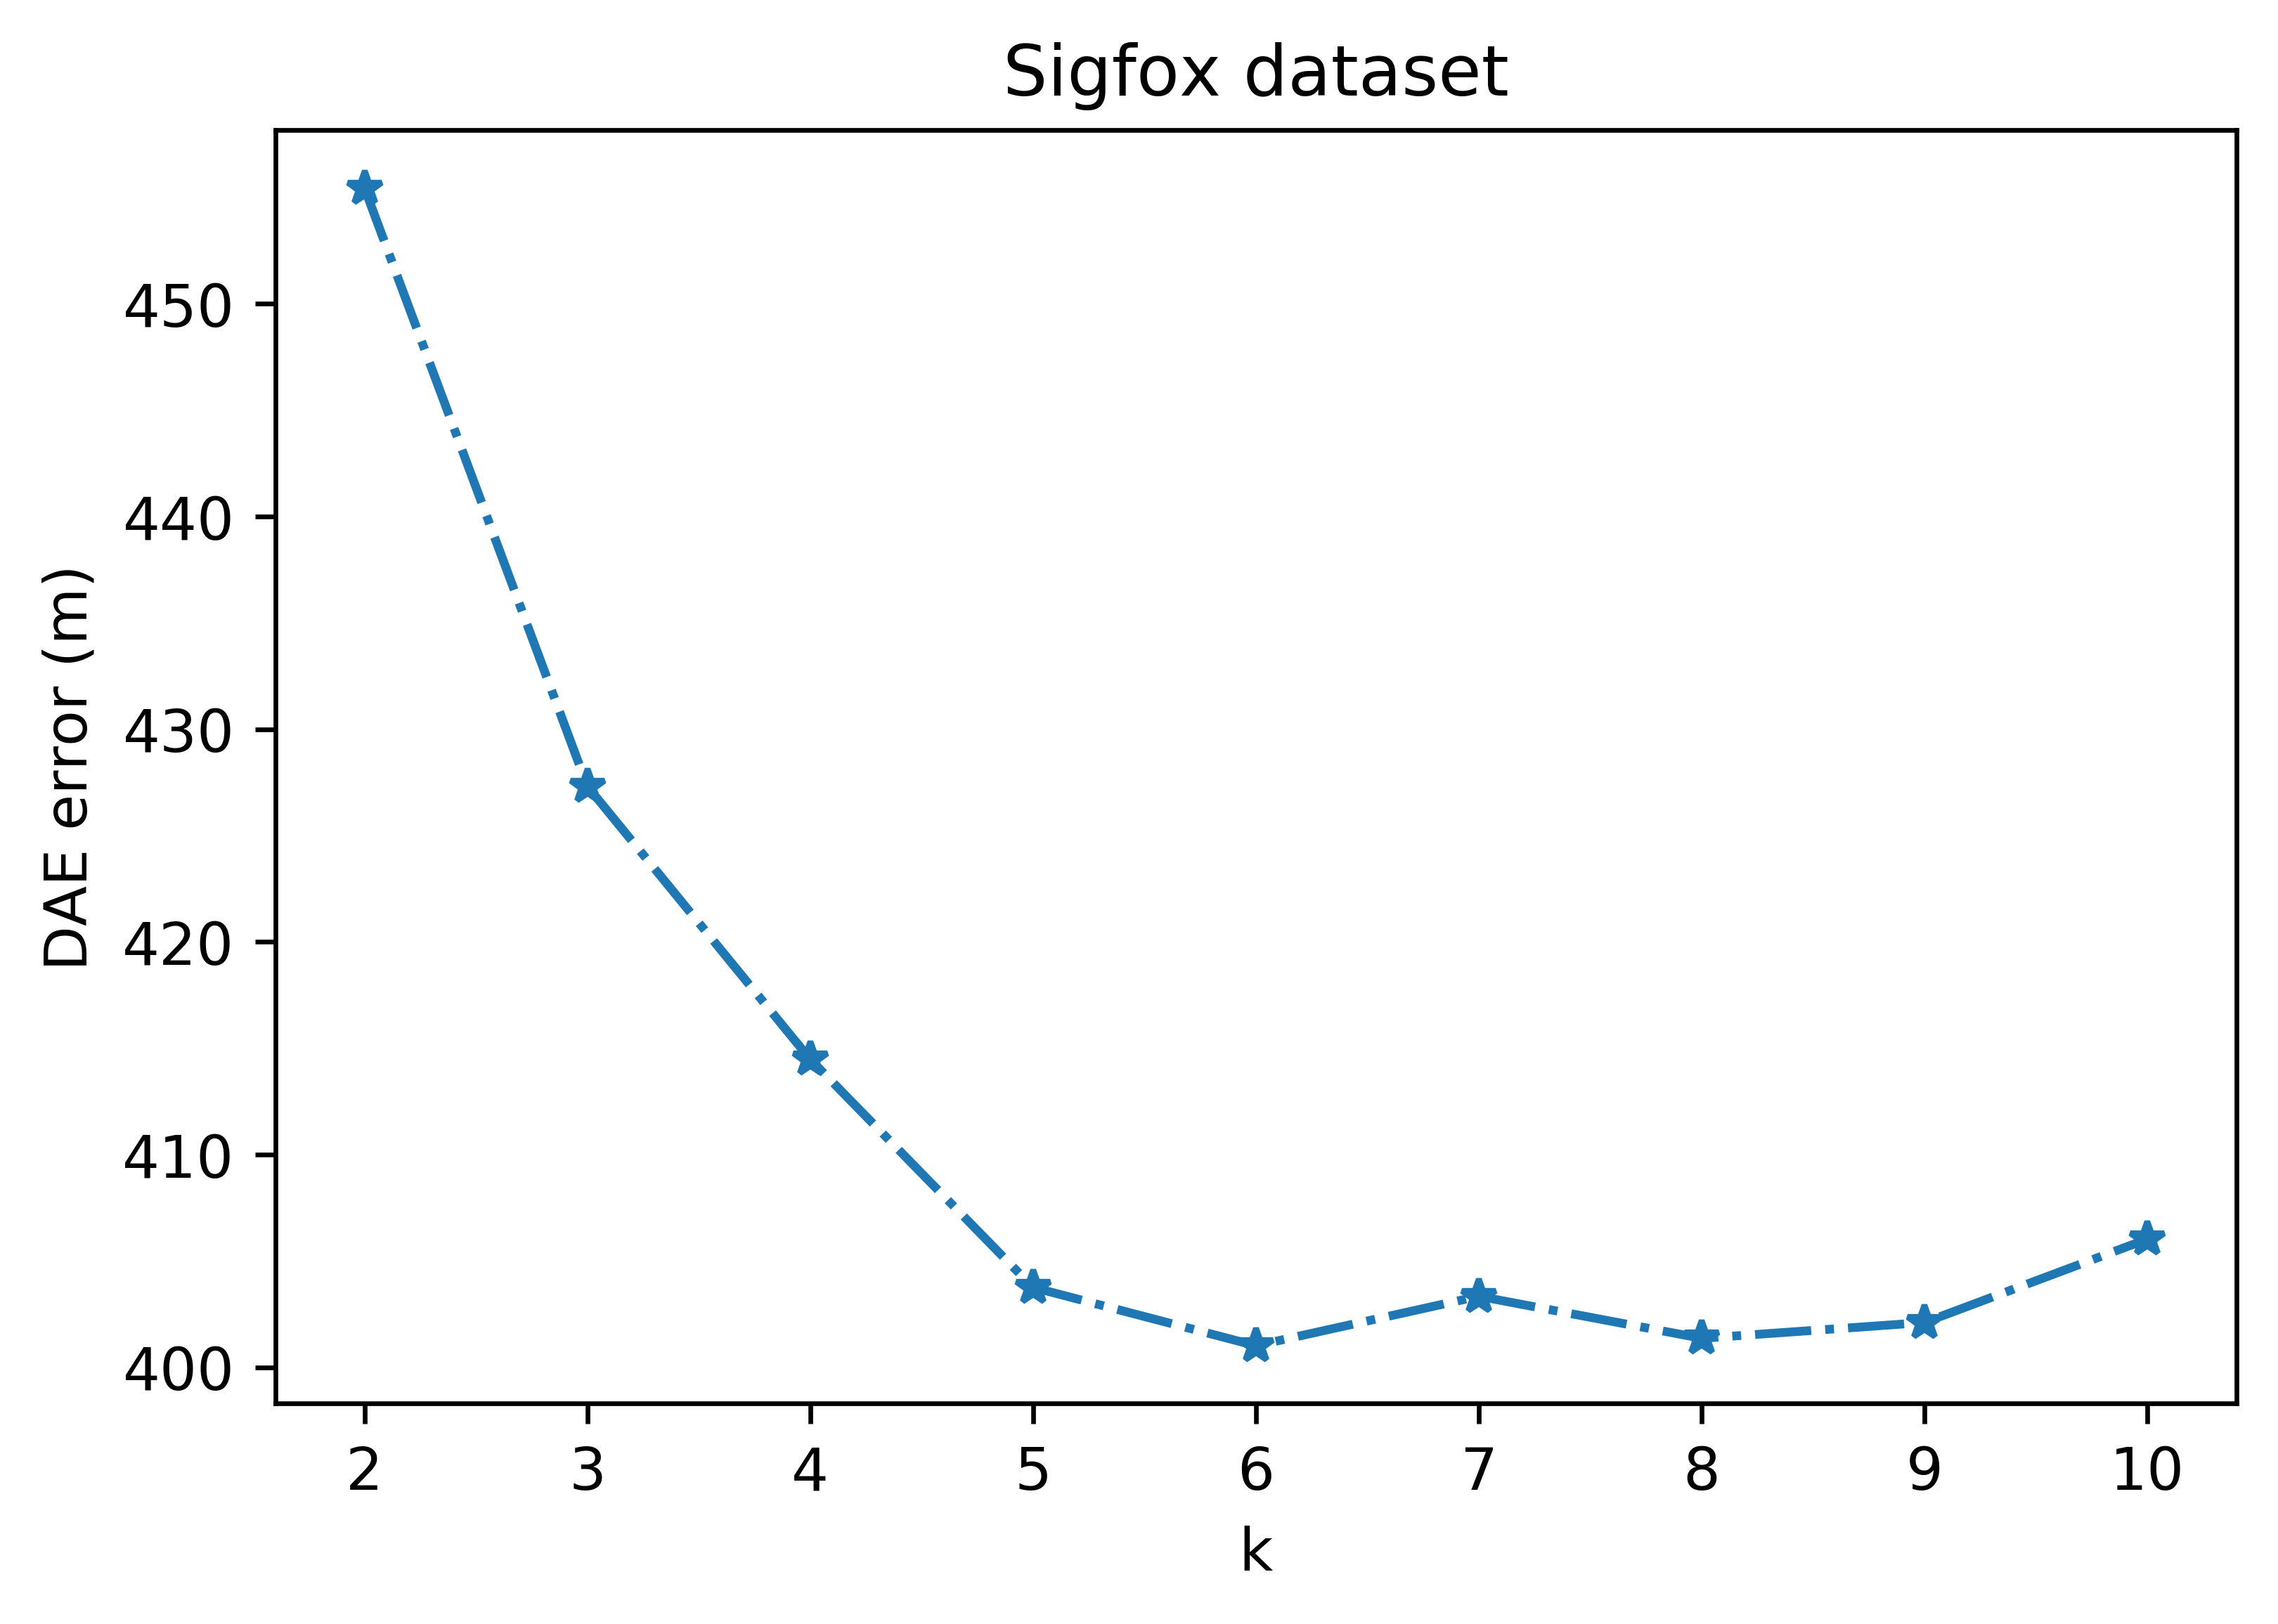

In [7]:
k_min = 2
k_max = 11
k , error_list = find_best_k_configuration_for_DAE(calculate_DAE_Lemelson,'Lemelson',x_train_1,y_train_1,x_val,_,y_M1_error_val,k_min, k_max, units)
DAE_val_Lemelson = calculate_DAE_Lemelson(x_train_1,y_train_1,x_val,k, units)    
DAE_miss_val_Lemelson = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_val_Lemelson))
mean_error =  np.mean(DAE_miss_val_Lemelson)
print('Best k =', k)
print('With mean error =', mean_error )

fig, ax = plt.subplots(dpi=600)
plt.plot(range(k_min,k_max),error_list , '-.*')
ax.set_xlabel('k')
ax.set_ylabel('DAE error (m)')
plt.title('Tuning k for DAE Lemelson')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")

plt.savefig('results/' + dataset + '/Tuning_Lemelson_' + dataset + '.png', dpi = 600)

# Marcus


2
266.72861319550873

3
267.5587478987008

4
267.43755421899374

5
267.96656047065

6
270.1671359932012

7
273.7198238330044

8
276.381741141225

9
279.08361806254584

10
284.0431184574554
Best k = 2
With mean error = 266.72861319550873


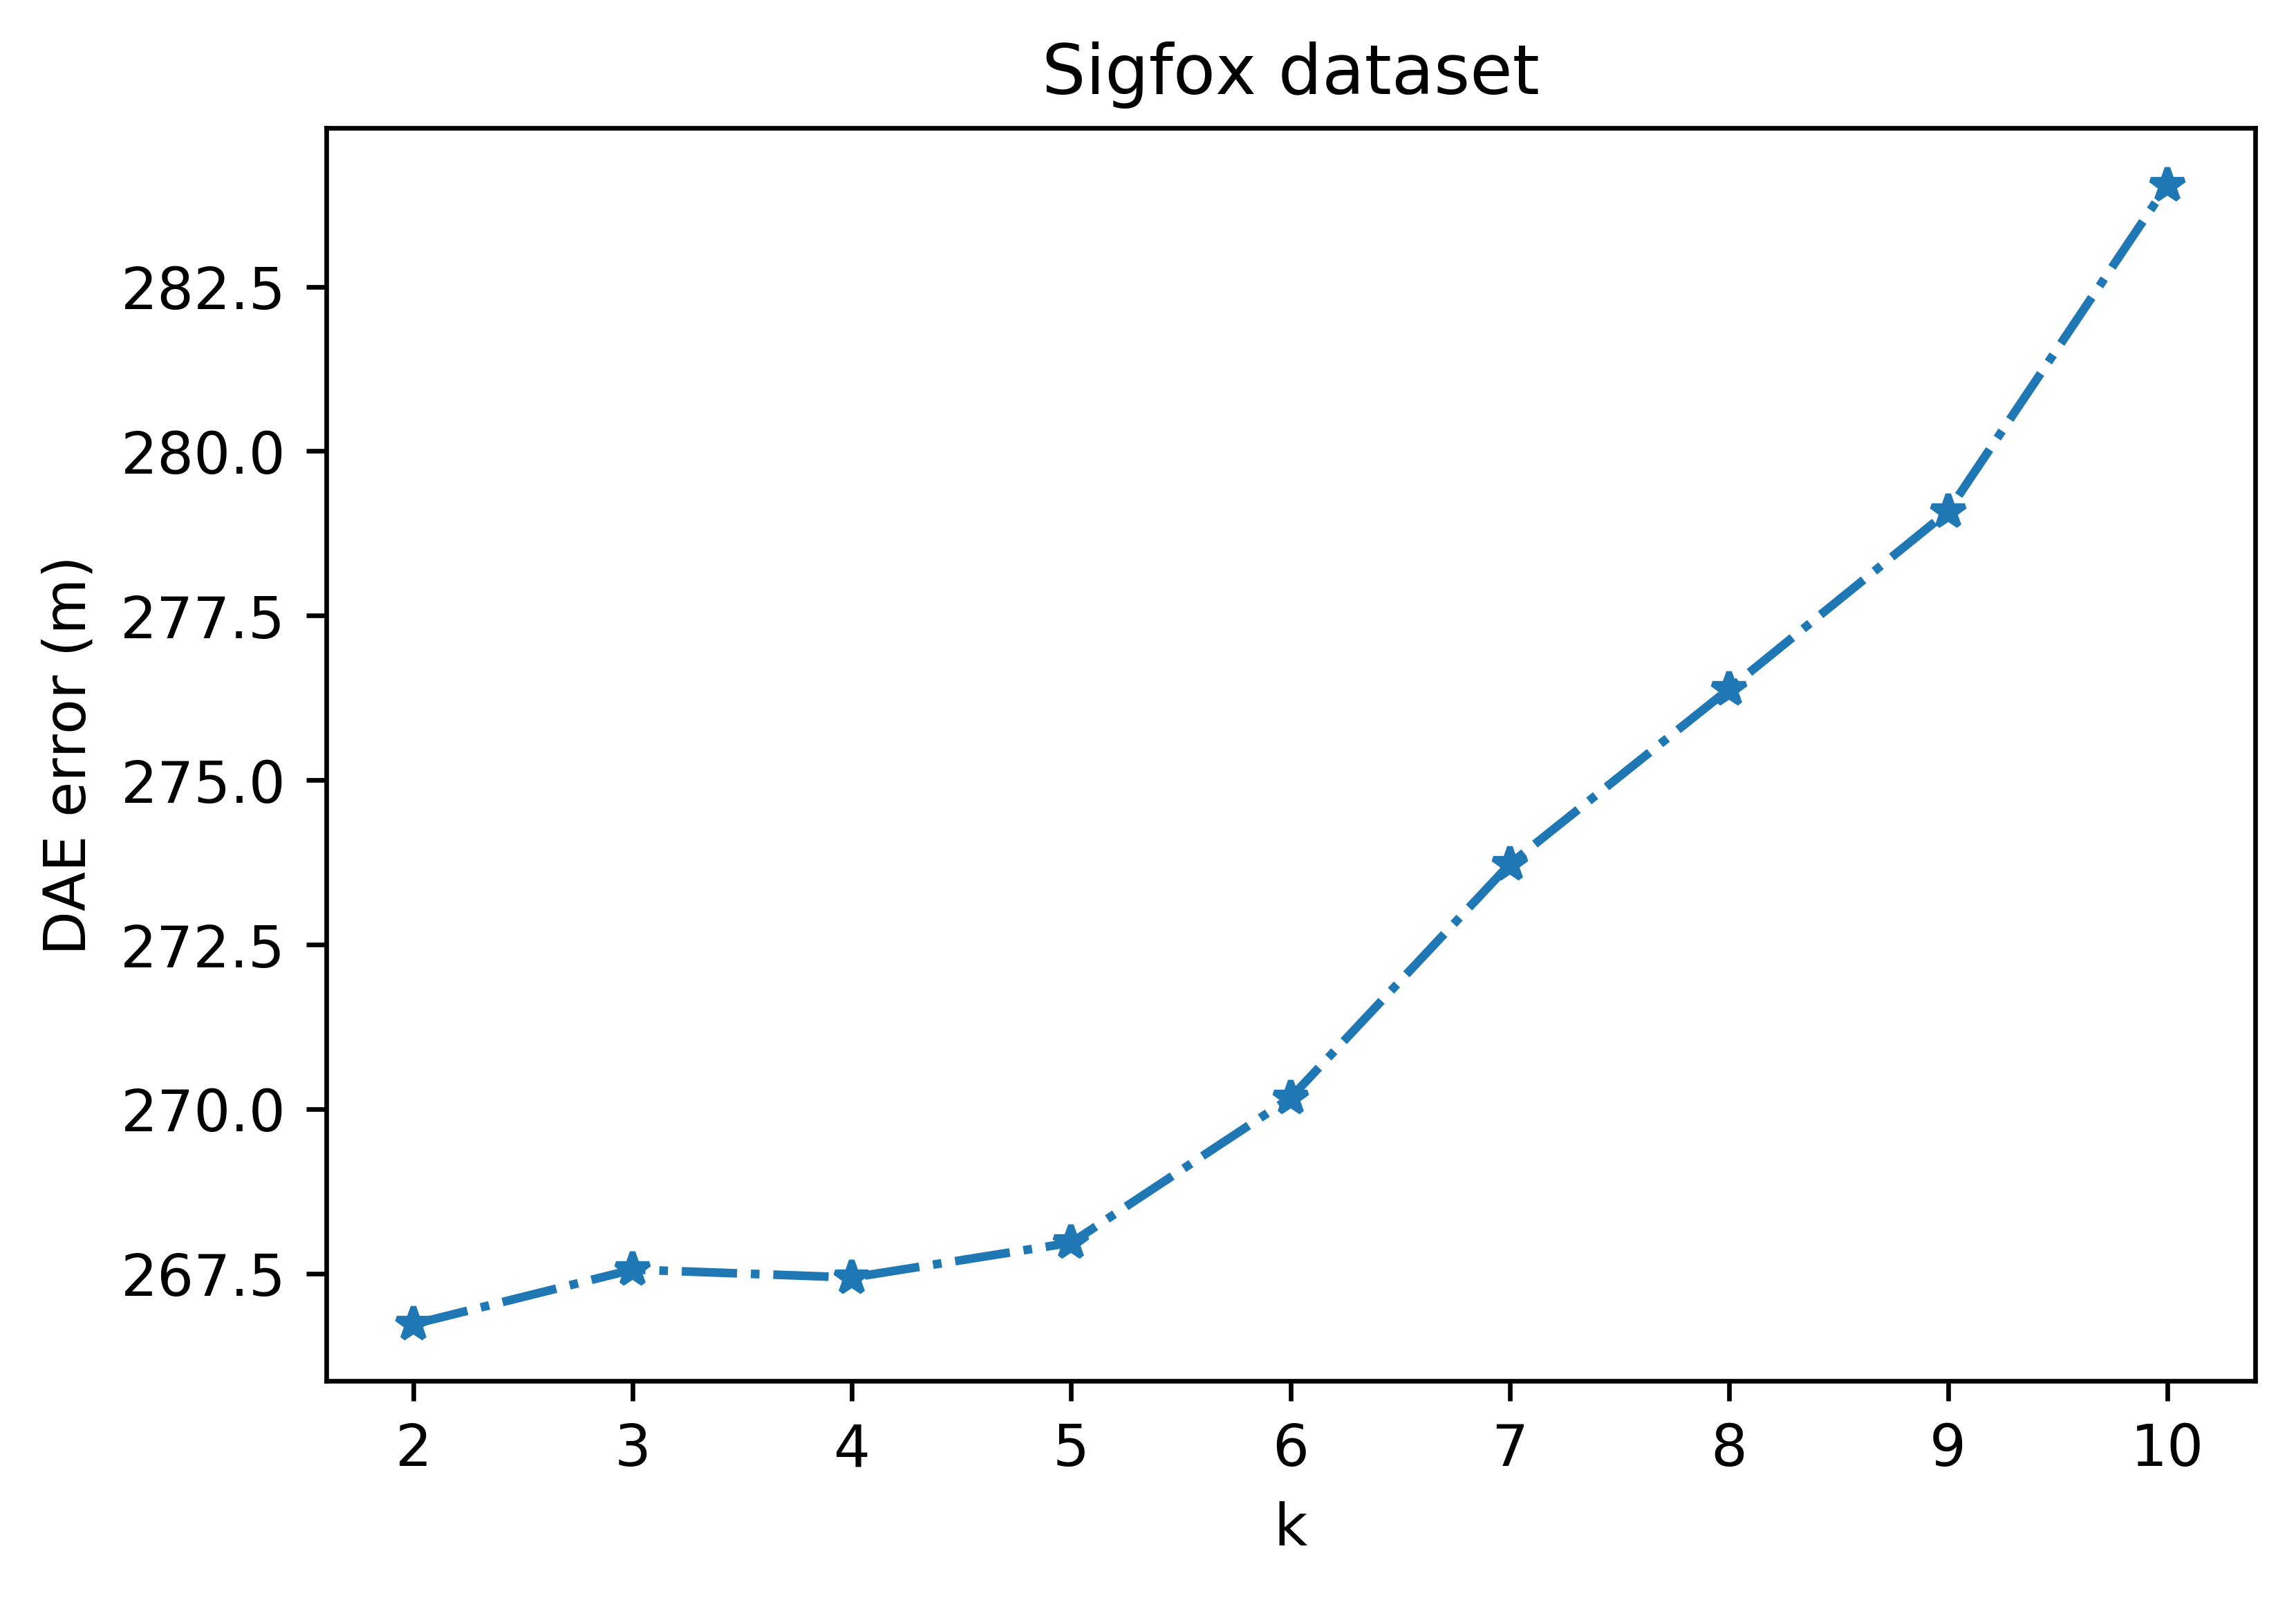

In [10]:
k_min = 2
k_max = 11
k , error_list = find_best_k_configuration_for_DAE(calculate_DAE_Marcus,'Marcus',x_train_1,y_train_1,x_val,y_M1_predict_in_val,y_M1_error_val,k_min,k_max, units)
DAE_val_Marcus = calculate_DAE_Marcus(x_train_1,y_train_1,x_val,y_M1_predict_in_val,k, units)    
DAE_miss_val_Marcus = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_val_Marcus))
mean_error =  np.mean(DAE_miss_val_Marcus)
print('Best k =', k)
print('With mean error =', mean_error )


fig, ax = plt.subplots(dpi=600)
plt.plot(range(k_min,k_max),error_list , '-.*')
ax.set_xlabel('k')
ax.set_ylabel('DAE error (m)')
plt.title('Tuning k for DAE Marcus')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")

plt.savefig('results/' + dataset + '/Tuning_Marcus_' + dataset + '.png', dpi = 600)

# Zou


2
266.8860095404925

3
268.5844768111237

4
268.3213231696874

5
269.6547315858998

6
271.7600565254034

7
276.80780536182095

8
279.8760154653556

9
283.1619976321969

10
289.3531614249107
Best k = 2
With mean error = 266.8860095404925


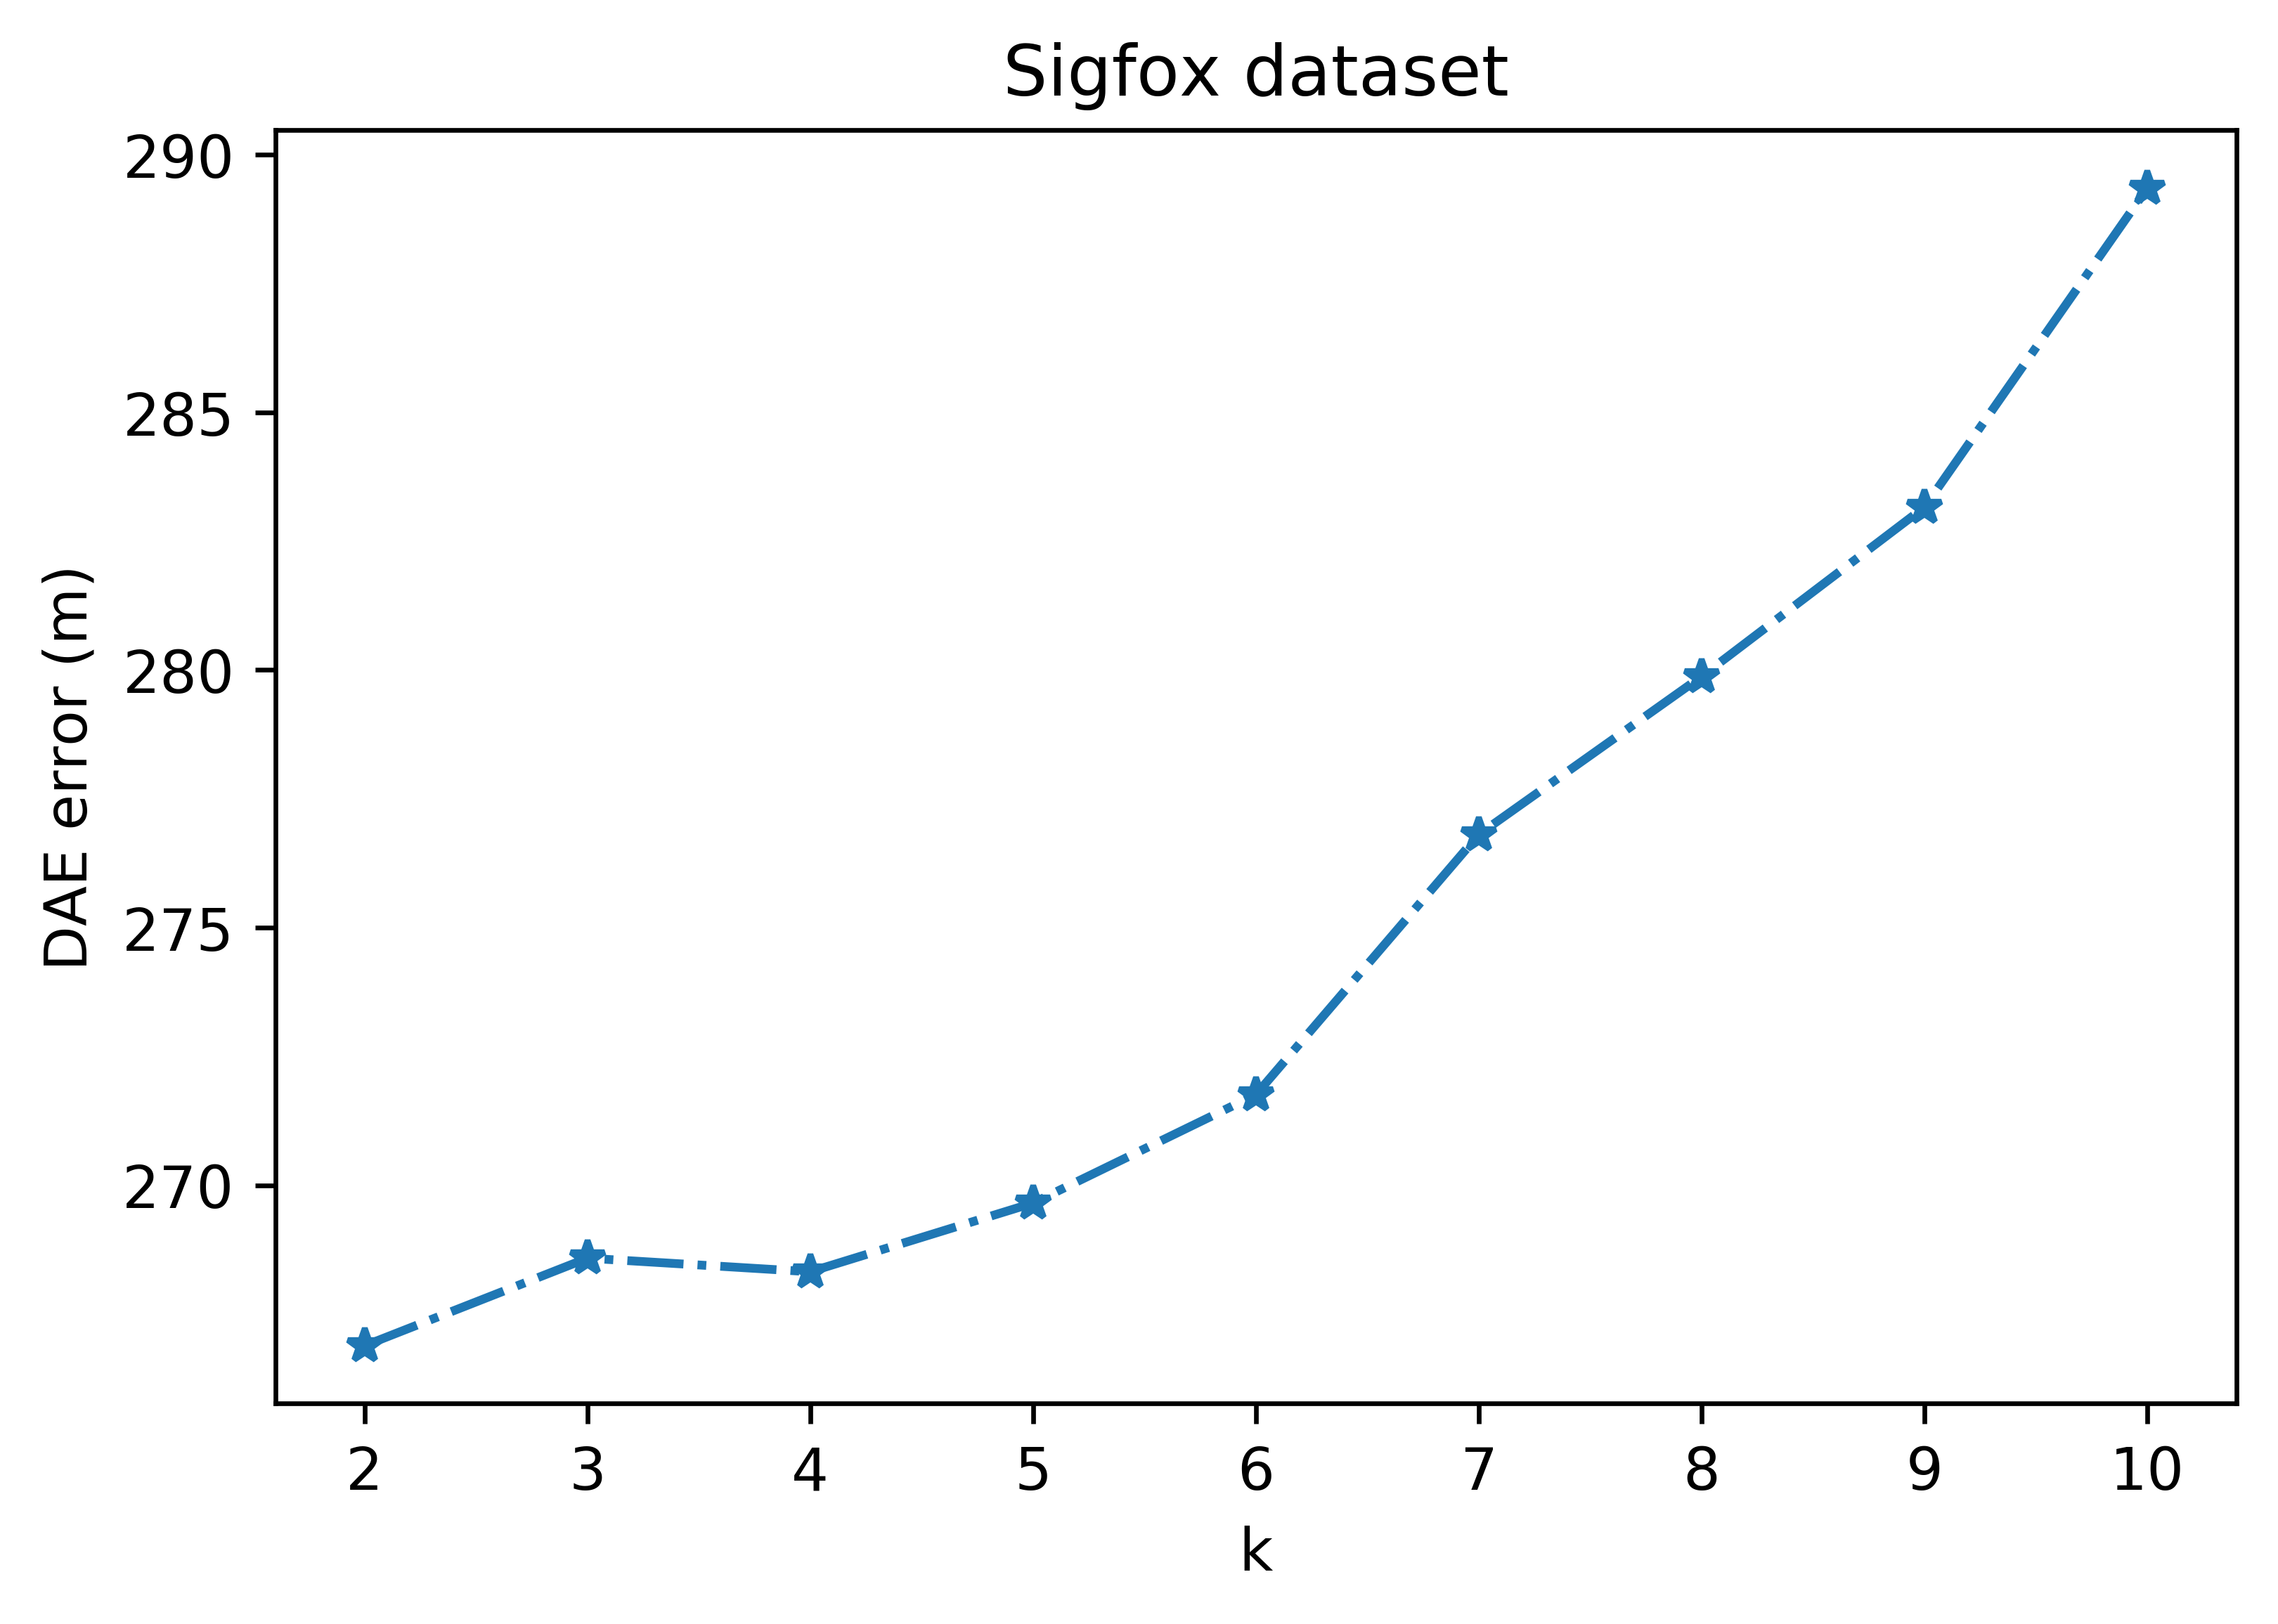

In [12]:
k_min = 2
k_max = 11
k , error_list = find_best_k_configuration_for_DAE(calculate_DAE_Zou,'Zou',x_train_1,y_train_1,x_val,y_M1_predict_in_val,y_M1_error_val,k_min,k_max,units)
DAE_val_Zou = calculate_DAE_Zou(x_train_1,y_train_1,x_val,y_M1_predict_in_val,k,'mean', units)    
DAE_miss_val_Zou = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_val_Zou))
mean_error =  np.mean(DAE_miss_val_Zou)
print('Best k =', k)
print('With mean error =', mean_error)


fig, ax = plt.subplots(dpi=600)
plt.plot(range(k_min,k_max),error_list , '-.*')
ax.set_xlabel('k')
ax.set_ylabel('DAE error (m)')
plt.title('Tuning k for DAE Zou')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")

plt.savefig('results/' + dataset + '/Tuning_Zou_' + dataset + '.png', dpi = 600)

# Baseline calculation

In [13]:
DAE_constant_mean, DAE_constant_median, DAE_uniform_random, DAE_normal_random = calculate_DAE_baselines(y_M1_error_train_2, x_val, random_state=random_state)

2157


# Boxplot of DAE error

In [14]:
# regrouping the lists of DAE error values of all methods in a dictionary
dict_of_error_list = dict()

dict_of_error_list['DD'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_in_val.tolist())))
dict_of_error_list['DDL'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_in_val_M1.tolist())))
dict_of_error_list['Lemelson'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_val_Lemelson)))
dict_of_error_list['Marcus'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_val_Marcus)))
dict_of_error_list['Zou'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_val_Zou)))

dict_of_error_list['CMN'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_constant_mean)))
dict_of_error_list['CMD'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_constant_median)))
dict_of_error_list['UR'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_uniform_random)))
dict_of_error_list['NR'] = list(abs(np.asarray(y_M1_error_val).reshape((-1,)) - np.asarray(DAE_normal_random)))

methods = list(dict_of_error_list.keys())

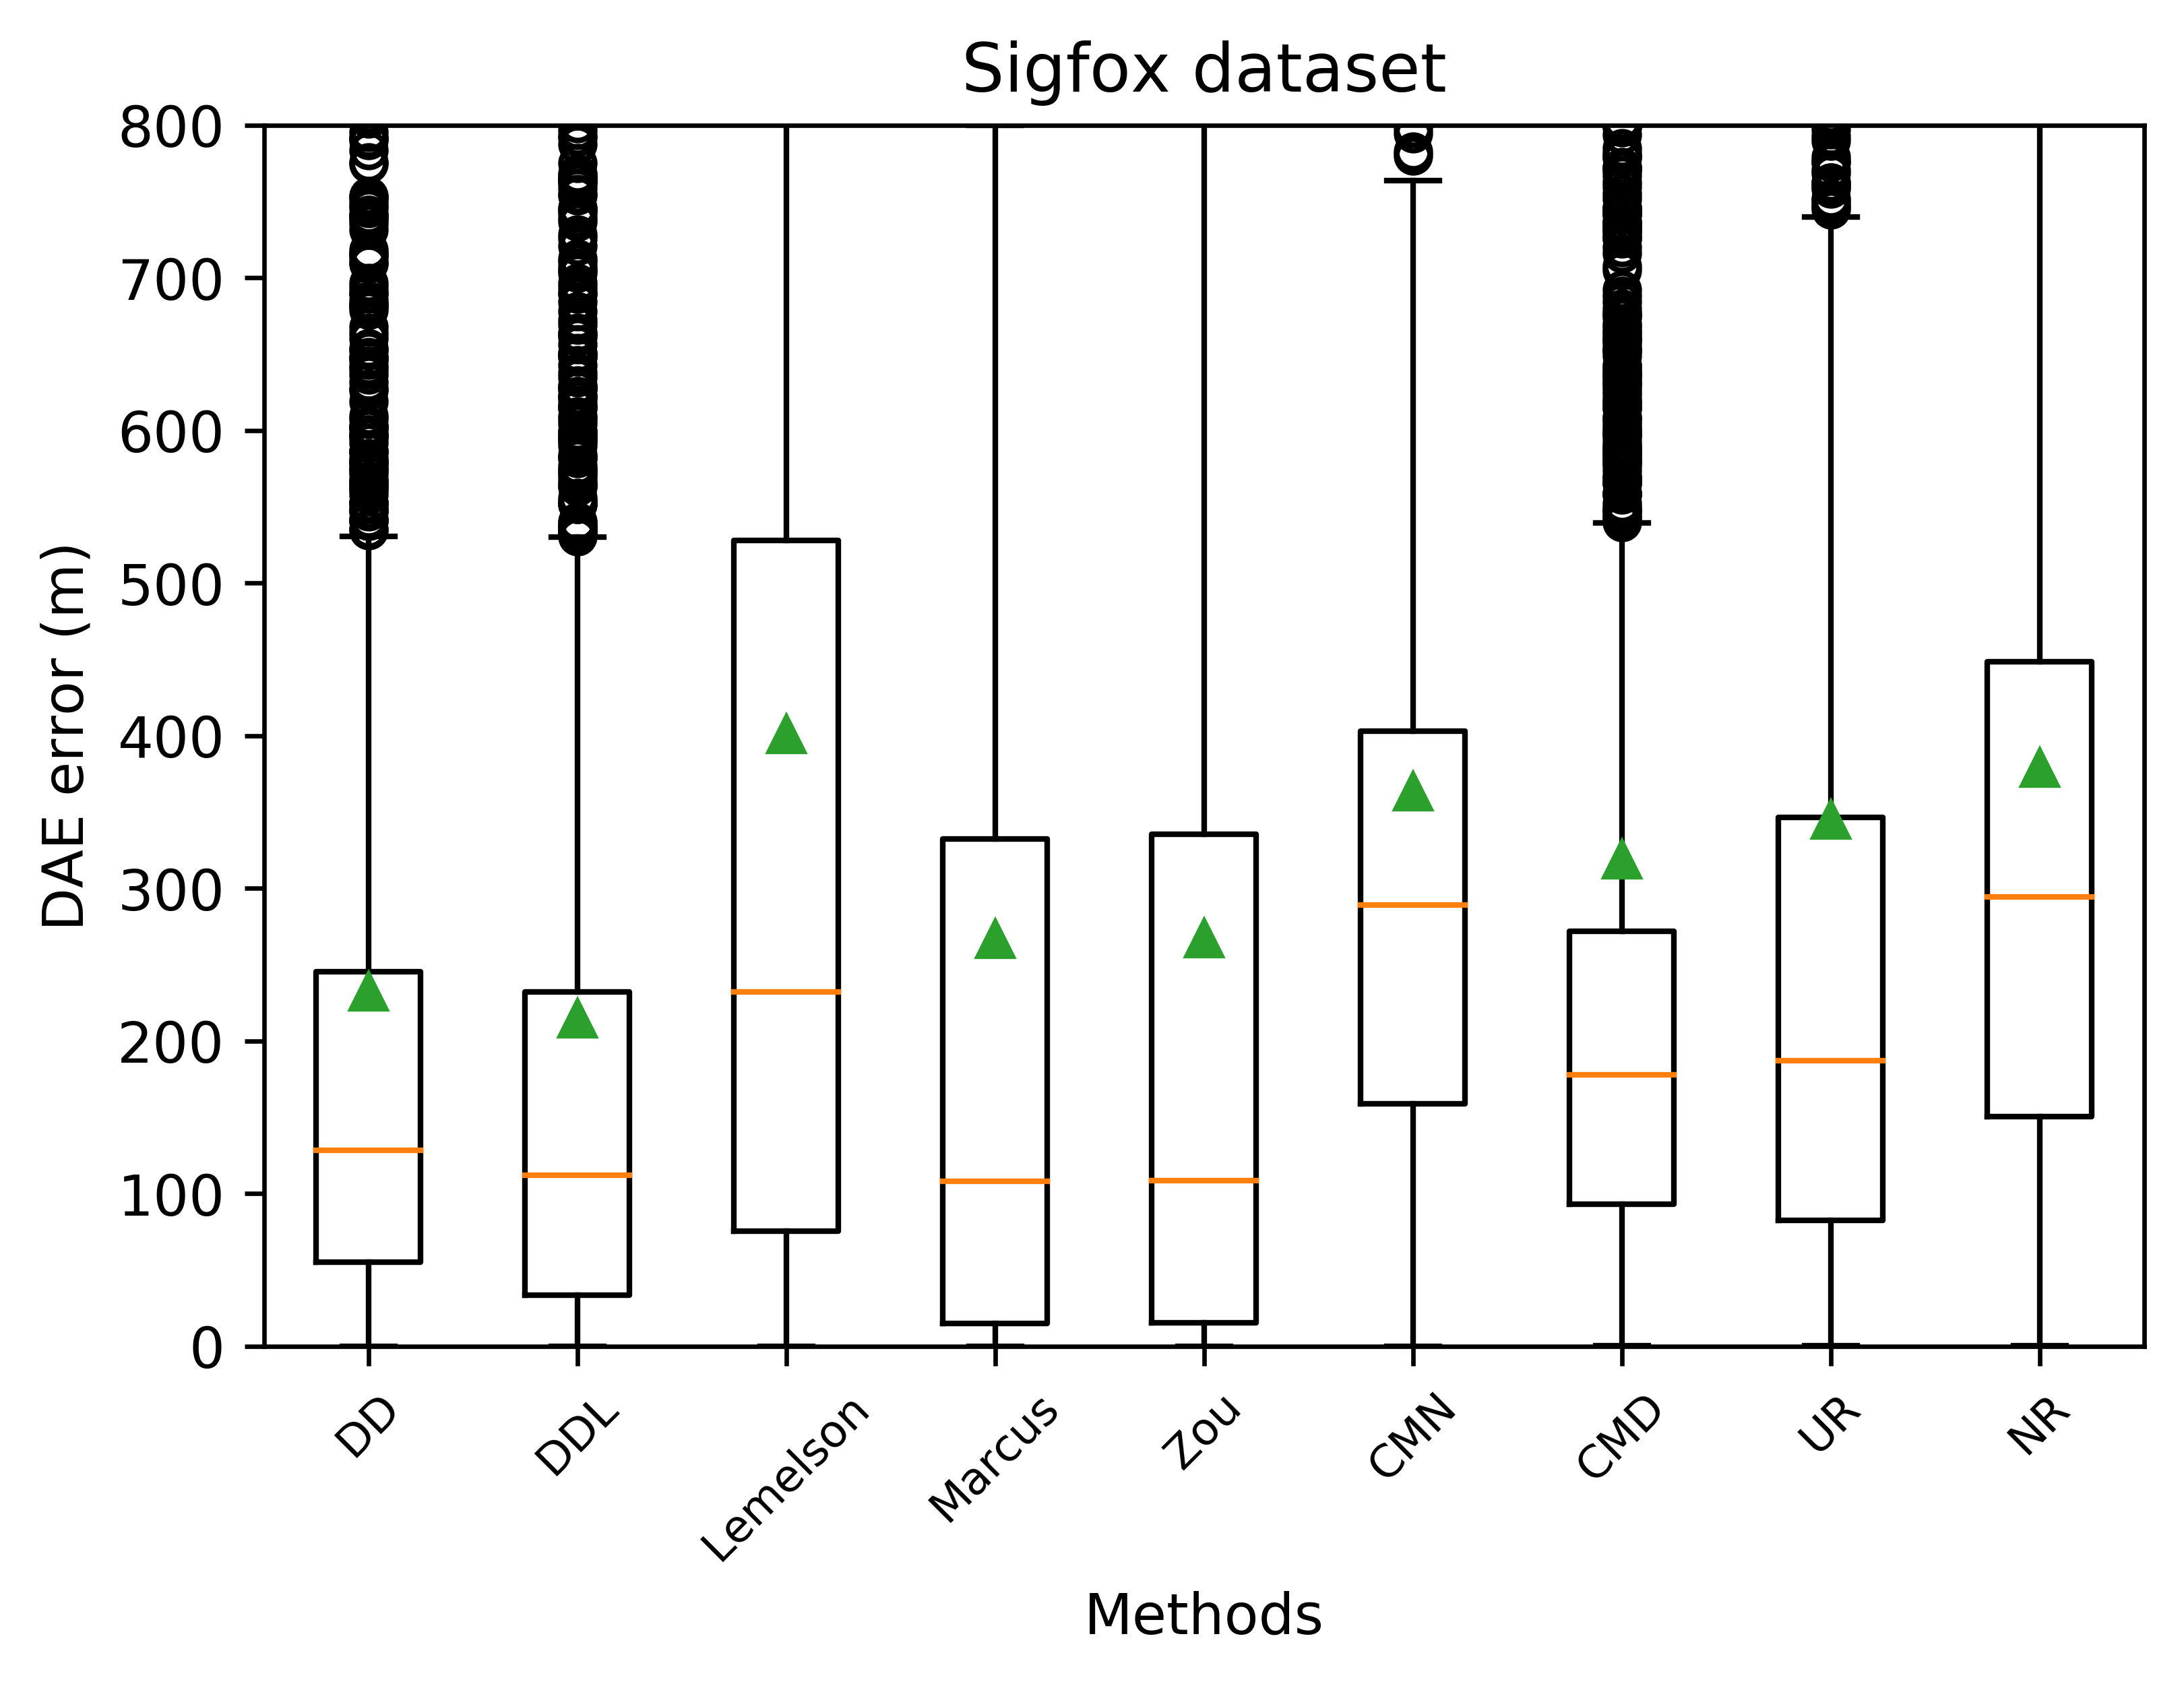

In [15]:
# creating the boxplot
fig, ax = plt.subplots(dpi=600)

if dataset == 'lorawan':
    ax.set( ylim=(0, 500))
elif dataset == 'sigfox':
    ax.set( ylim=(0, 800))     
elif dataset == 'DSI':
    ax.set( ylim=(0, 10))  
elif dataset == 'MAN':
    ax.set( ylim=(0, 10)) 
# ax.set( ylim=(0, 500))
ax.set_xlabel('Methods')
ax.set_ylabel('DAE error (m)')
ax.set_xticklabels(methods,
                    rotation=45, fontsize=8)
plt.boxplot(dict_of_error_list.values(), showmeans=True) 
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/boxplots_DAE_error_' + dataset + '.png', dpi = 600, bbox_inches= 'tight')

# Selection of position estimates

In [16]:
# regrouping the lists of DAE estimates of all methods in a dictionary
dict_of_DAE_lists = OrderedDict()
dict_of_DAE_lists['DD']  = DAE_in_val.tolist()
dict_of_DAE_lists['DDL'] = DAE_in_val_M1.tolist()
dict_of_DAE_lists['Lemelson'] = DAE_val_Lemelson
dict_of_DAE_lists['Marcus'] = DAE_val_Marcus
dict_of_DAE_lists['Zou'] = DAE_val_Zou

In [17]:
# color dictionary definition for consistent coloring of methods
tabl = list(mcolors.TABLEAU_COLORS.values())

dict_of_colors = OrderedDict()
dict_of_colors['DD'] = tabl[0]
dict_of_colors['DDL'] = tabl[1]
dict_of_colors['Lemelson'] = tabl[2]
dict_of_colors['Marcus'] = tabl[3]
dict_of_colors['Zou'] = tabl[4]

dict_of_colors['CMN'] = tabl[5]
dict_of_colors['CMD'] = tabl[6]
dict_of_colors['UR'] = tabl[7]
dict_of_colors['NR'] = tabl[8]

<Figure size 432x288 with 0 Axes>

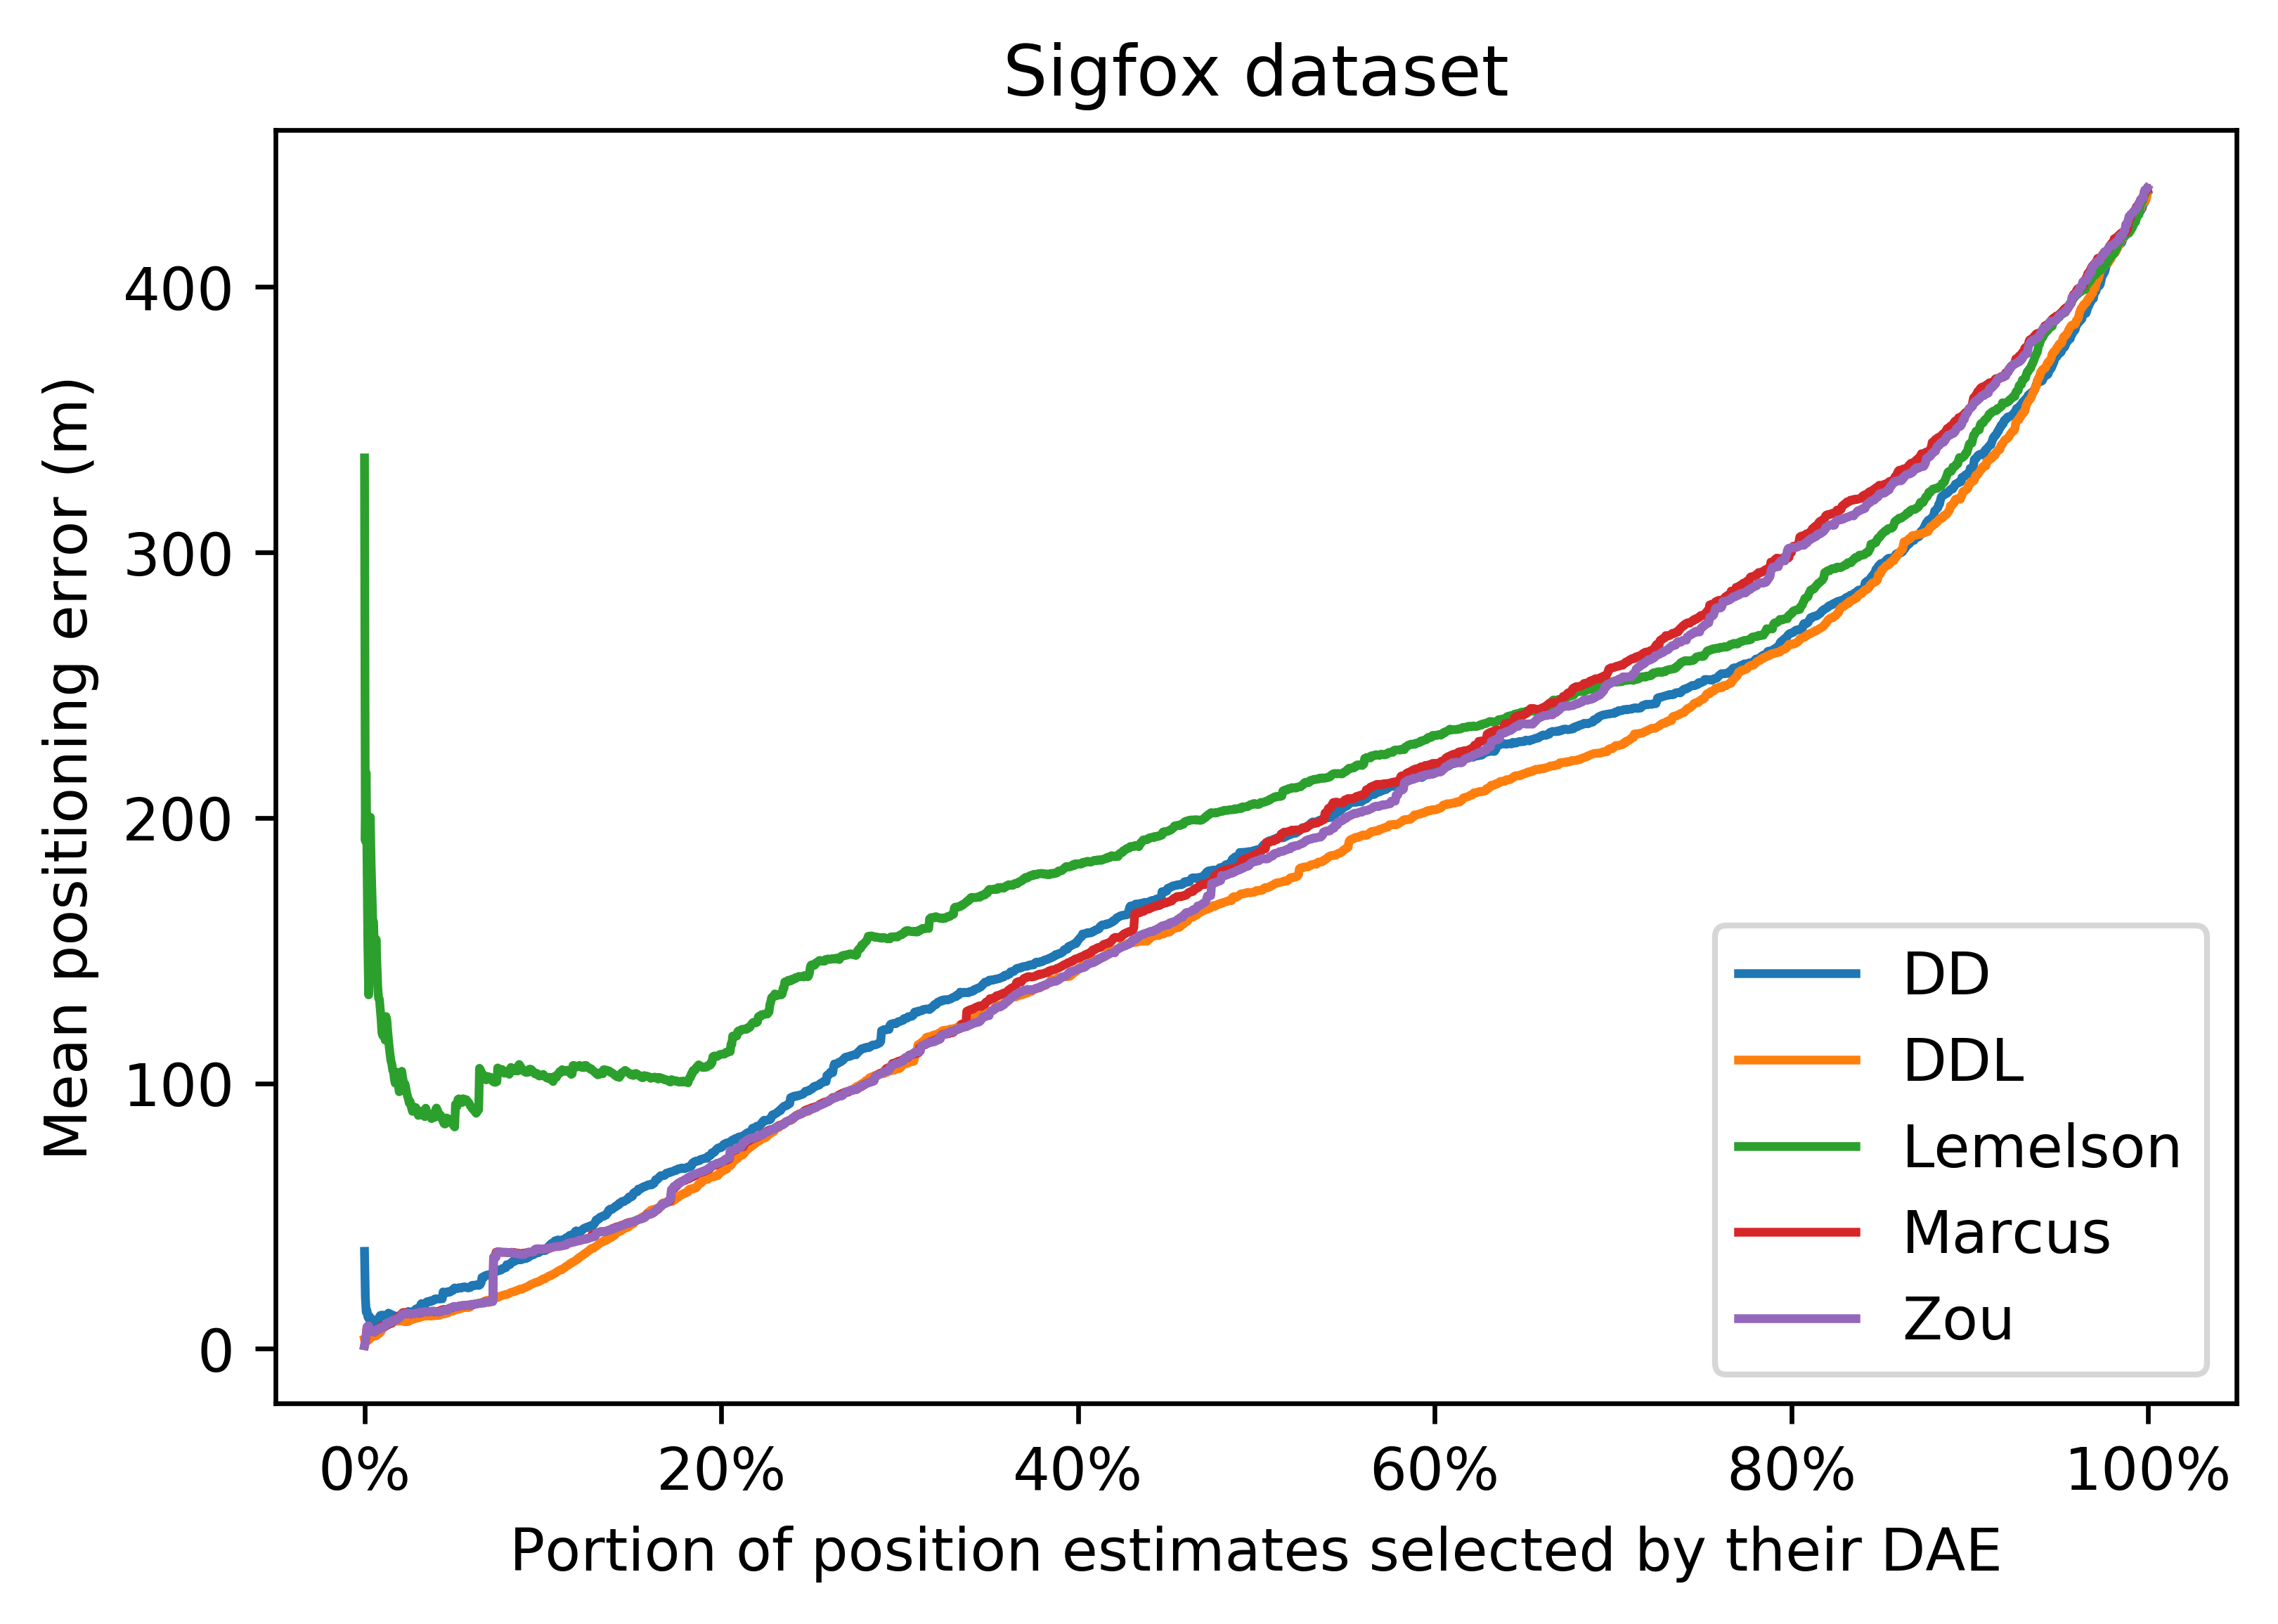

In [18]:
# plot mean positioning error, w.r.t. the percentage of selected points, based on DAE
plt.figure()
fig, ax = plt.subplots(dpi=600)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
list_of_lists_of_shorted_M1_errors = []
j=0
for key, DAE_list in dict_of_DAE_lists.items():
    c = dict_of_colors[key]
    
    # sorting
    indeces_2 = np.argsort(DAE_list)
    y_error_val_sorted_by_pred = [y_M1_error_val[indeces_2[i]] for i in range(len(DAE_list))] 
    y_val_sorted_by_pred = y_val[indeces_2]
    y_M1_predict_in_val_sorted_by_pred  = y_M1_predict_in_val[indeces_2]

    # Plotting mean error of different portions of the validation set, sorted based on the DAE
    moving_average_M1_error = list()
    moving_median_M1_error = list()  # not used, calculated as an alternative
    for i in range (1,len(y_error_val_sorted_by_pred)):
        moving_average_M1_error.append(np.mean(y_error_val_sorted_by_pred[0:i]))
        moving_median_M1_error.append(np.median(y_error_val_sorted_by_pred[0:i])) 

    # the values of the x axis to represent the percentage of points used
    percentages = [(100*i/len(moving_average_M1_error)) for i in range(len(moving_average_M1_error))]
    ax.set_xlabel('Portion of position estimates selected by their DAE')
    ax.set_ylabel('Mean positioning error (m)')
    ax.plot(percentages,moving_average_M1_error,c)
    j=j+1
    
loc='upper left'
if dataset == 'sigfox':
    loc='lower right'
elif dataset == 'DSI':
    ax.set( ylim=(0, 12))
    loc='upper right'
elif dataset == 'MAN':
    ax.set( ylim=(0, 6)) 
    loc='lower right'
plt.legend(methods, loc=loc)

if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/sorted_errors_' + dataset + '.png', dpi = 600)

# Merging all results in a DataFrame

In [19]:
# calculating all relevant evaluation metrics of all methods in a DataFrame
list_of_dicts = []
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_in_val.tolist(),'DD'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_in_val_M1.tolist(),'DDL'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_val_Lemelson,'Lemelson'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_val_Marcus,'Marcus'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_val_Zou,'Zou'))

list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_constant_mean,'CMN'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_constant_median,'CMD'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_uniform_random,'UR'))
list_of_dicts.append(calculate_DAE_evaluation_metrics(y_M1_error_val,DAE_normal_random,'NR'))

df = p.DataFrame(list_of_dicts)

DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)
DAE_miss_singed (2157,)
DAE_miss (2157,)


/opt/anaconda3/envs/torch/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/torch/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/envs/torch/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/envs/torch/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/envs/torch/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [16]:
df

method_name  mean  median  75th  90th   std   ov%  ov_md  ov_mn  un_md  \
0          DD  1.39    1.56  1.90  2.47  0.88  48.0   1.70   1.57   1.08   
1         DDL  1.37    1.34  1.88  2.17  0.85  44.0   1.65   1.65   0.88   
2    Lemelson  4.14    3.77  5.45  8.29  3.26  84.0   4.16   4.65   1.08   
3      Marcus  2.85    2.16  3.99  5.60  2.29  84.0   3.05   3.22   0.87   
4         Zou  2.89    2.21  3.67  5.77  2.28  84.0   3.02   3.26   0.96   
5         CMN  1.52    1.07  1.91  2.68  1.38  56.0   0.91   1.35   1.17   
6         CMD  1.52    1.49  2.13  2.30  1.47  44.0   1.25   1.14   1.58   
7          UR  2.94    2.98  3.87  4.68  1.75  20.0   1.07   0.90   3.42   
8          NR  1.54    1.28  1.87  2.15  1.47  48.0   1.44   1.51   1.08   

   un_mn  Pearson  Spearman  
0   1.22   0.6017    0.2046  
1   1.14   0.6259    0.3131  
2   1.44   0.2333    0.1750  
3   0.89   0.3885    0.4554  
4   0.94   0.3876    0.4492  
5   1.73  -0.0000       NaN  
6   1.81      NaN       NaN  
7   3.45   0.0655   -0.0881  
8   1.58  -0.0284    0.1108

# Radar plot creation

In [17]:
# Adapted code, taken from https://gist.github.com/kylerbrown/29ce940165b22b8f25f4

from matplotlib.ticker import MaxNLocator

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata


class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables, fontsize=20)
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,3)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
                gridlabel.reverse()
                gridlabel[-1] = "" # clean up origin
                gridlabel[0] = "" # clean up end
            else:                
                gridlabel[0] = "" # clean up origin
                gridlabel[-1] = "" # clean up end
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i], fontsize=15)            
            for label in ax.xaxis.get_ticklabels():
                label.set_color('m')
                label.set_fontsize(30)
            ax.set_ylim(*ranges[i])
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

/home/greg/anaconda2/envs/env_lorawan/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


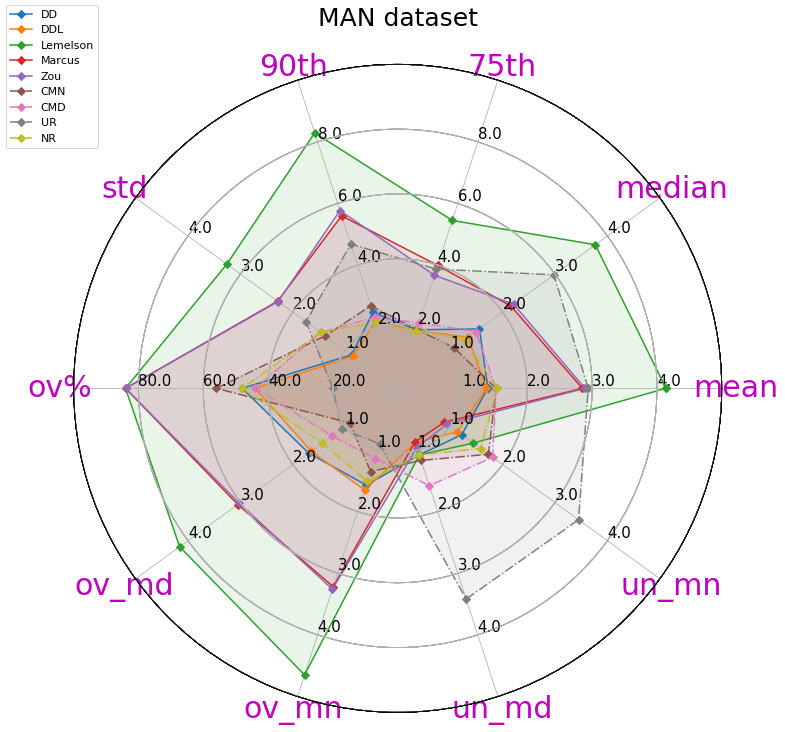

In [18]:
categories=list(df)[1:-2] 
variables = categories
N = len(categories)
method_names = df['method_name'].tolist()

# ranges adapted to datasets, for better visual result
if dataset == 'lorawan':
    ranges = [(0, 250),
              (0, 250),
              (0, 500),
              (0, 625),
              (0, 375),
              (30, 80),
              (0, 250),
              (0, 375),  
              (0, 250),
              (0, 375)
             ]       
elif dataset == 'sigfox':
    ranges = [(0, 500),
              (0, 375),
              (0, 625),
              (0, 1125),
              (0, 625),
              (0, 80),
              (0, 375),
              (0, 500),  
              (0, 375),
              (0, 625)
             ]       
elif dataset == 'DSI':
    ranges = [(0, 10),
          (0, 5),
          (0, 10),
          (0, 15),
          (0, 5),
          (0, 75),
          (0, 5),
          (0, 5),
          (0, 5),
          (0, 10)
         ]       
elif dataset == 'MAN':
    ranges = [(0, 5),
          (0, 5),
          (0, 10),
          (0, 10),
          (0, 5),
          (0, 100),
          (0, 5),
          (0, 5),
          (0, 5),
          (0, 5)
             ]


# plotting
fig1 = plt.figure(figsize=(N, N))
    
for i in range(df.shape[0]):
    data = df.loc[i].drop('method_name').values.flatten().tolist()
    c = dict_of_colors[method_names[i]]
    l = '-'
    if method_names[i] == 'CMN' or method_names[i] == 'CMD' or method_names[i] == 'UR' or method_names[i] == 'NR':
        l = '-.'
    radar = ComplexRadar(fig1, variables , ranges)
    radar.plot(data , c=c,linestyle = l, marker = 'D',markersize=6)
    radar.fill(data, alpha=0.1)

fig1.legend(methods[0:df.shape[0]], loc='upper left', prop={'size': 11})

if dataset == "lorawan":
    plt.title("LoRaWAN dataset", fontsize=25)
elif dataset == "sigfox":
    plt.title("Sigfox dataset", fontsize=25)
else:
    plt.title(dataset + " dataset", fontsize=25)
    
plt.show()    
fig1.savefig('results/' + dataset + '/radar_plot_' + dataset + '.png', dpi = 80, bbox_inches= 'tight',pad_inches=0.1)

# Correlation and scatter plots

Pearson= 0.6017227007333116
Spearman= 0.20461538461538462
Spearman pi= 0.3265277832159157
Pearson= 0.6259108248186843
Spearman= 0.3130769230769231
Spearman pi= 0.12754687047443294
Pearson= -0.028430039295845512
Spearman= 0.11076923076923079
Spearman pi= 0.5981115617639339
Pearson= 0.2333348559031028
Spearman= 0.1750336635571066
Spearman pi= 0.40267594008592533
Pearson= 0.3885292165390624
Spearman= 0.4553846153846154
Spearman pi= 0.022166685245949634
Pearson= 0.3875743388034513
Spearman= 0.44923076923076927
Spearman pi= 0.024273140553570587


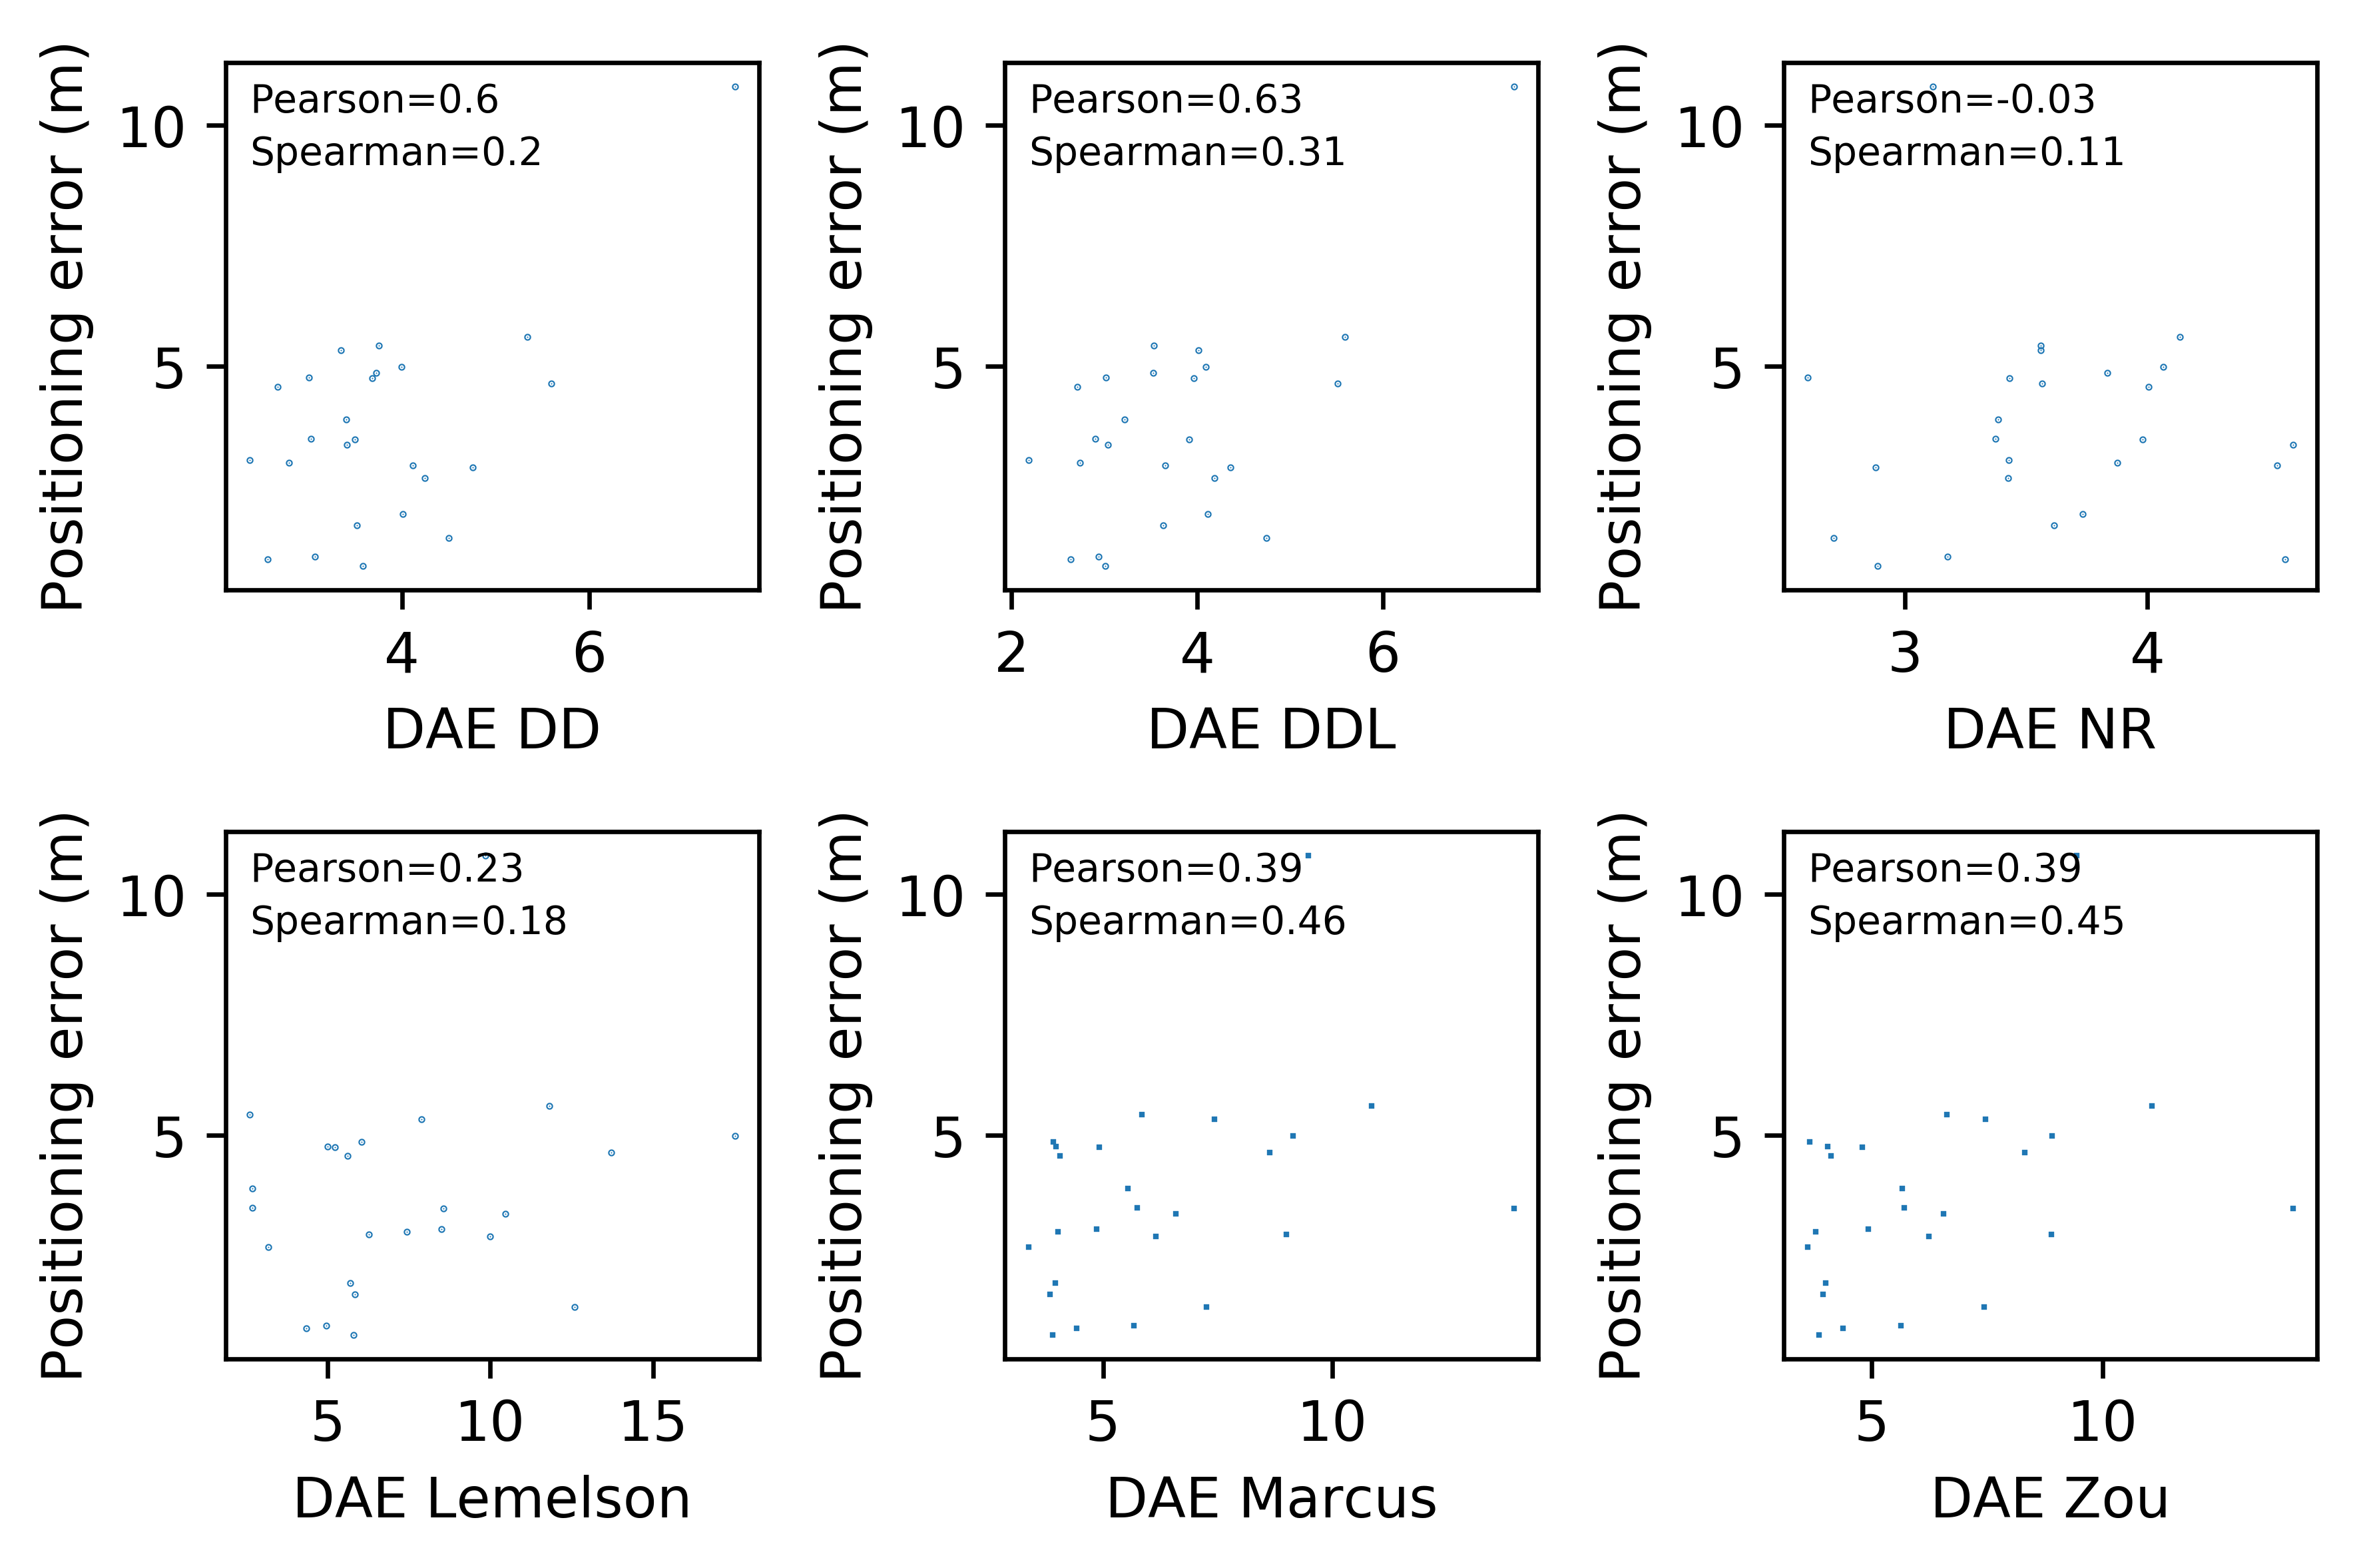

In [19]:
fig, axs = plt.subplots(2,3, dpi=600)

# DD
Pearson = np.corrcoef(DAE_in_val,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_in_val,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[0, 0].plot(DAE_in_val,y_M1_error_val ,'.',markersize=0.5)
axs[0, 0].text(max(0.5,min(DAE_in_val)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[0, 0].text(max(0.5,min(DAE_in_val)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[0, 0].set_xlabel('DAE DD')
axs[0, 0].set_ylabel('Positioning error (m)')

# DDL
Pearson = np.corrcoef(DAE_in_val_M1,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_in_val_M1,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[0, 1].plot(DAE_in_val_M1,y_M1_error_val ,'.',markersize=0.5)
axs[0, 1].text(max(0.5,min(DAE_in_val_M1)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[0, 1].text(max(0.5,min(DAE_in_val_M1)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[0, 1].set_xlabel('DAE DDL')
axs[0, 1].set_ylabel('Positioning error (m)')

# NR
Pearson = np.corrcoef(DAE_normal_random,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_normal_random,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[0, 2].plot(DAE_normal_random,y_M1_error_val ,'.',markersize=0.5)
axs[0, 2].text(max(0.5,min(DAE_normal_random)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[0, 2].text(max(0.5,min(DAE_normal_random)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[0, 2].set_xlabel('DAE NR')
axs[0, 2].set_ylabel('Positioning error (m)')

# Lemelson
Pearson = np.corrcoef(DAE_val_Lemelson,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_val_Lemelson,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[1, 0].plot(DAE_val_Lemelson,y_M1_error_val,'.',markersize=0.5)
axs[1, 0].text(max(0.5,min(DAE_val_Lemelson)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[1, 0].text(max(0.5,min(DAE_val_Lemelson)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[1, 0].set_xlabel('DAE Lemelson')
axs[1, 0].set_ylabel('Positioning error (m)')

# Marcus
Pearson = np.corrcoef(DAE_val_Marcus,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_val_Marcus,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[1, 1].plot(DAE_val_Marcus,y_M1_error_val,'+',markersize=1)
axs[1, 1].text(max(0.5,min(DAE_val_Marcus)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[1, 1].text(max(0.5,min(DAE_val_Marcus)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[1, 1].set_xlabel('DAE Marcus')
axs[1, 1].set_ylabel('Positioning error (m)')

# Zou
Pearson = np.corrcoef(DAE_val_Zou,y_M1_error_val)[0,1]
Spearman, pi = spearmanr(DAE_val_Zou,y_M1_error_val)
print('Pearson=', Pearson)
print('Spearman=', Spearman)
print('Spearman pi=', pi)
axs[1, 2].plot(DAE_val_Zou,y_M1_error_val,'+',markersize=1)
axs[1, 2].text(max(0.5,min(DAE_val_Zou)),0.95*max(y_M1_error_val), r'Pearson='+str(np.around(Pearson,decimals=2)), fontsize=7)
axs[1, 2].text(max(0.5,min(DAE_val_Zou)),0.85*max(y_M1_error_val), r'Spearman='+str(np.around(Spearman,decimals=2)), fontsize=7)
axs[1, 2].set_xlabel('DAE Zou')
axs[1, 2].set_ylabel('Positioning error (m)')

fig.tight_layout()
plt.savefig('results/' + dataset + '/scatter_' + dataset + '.png', dpi = 600)

# CDF

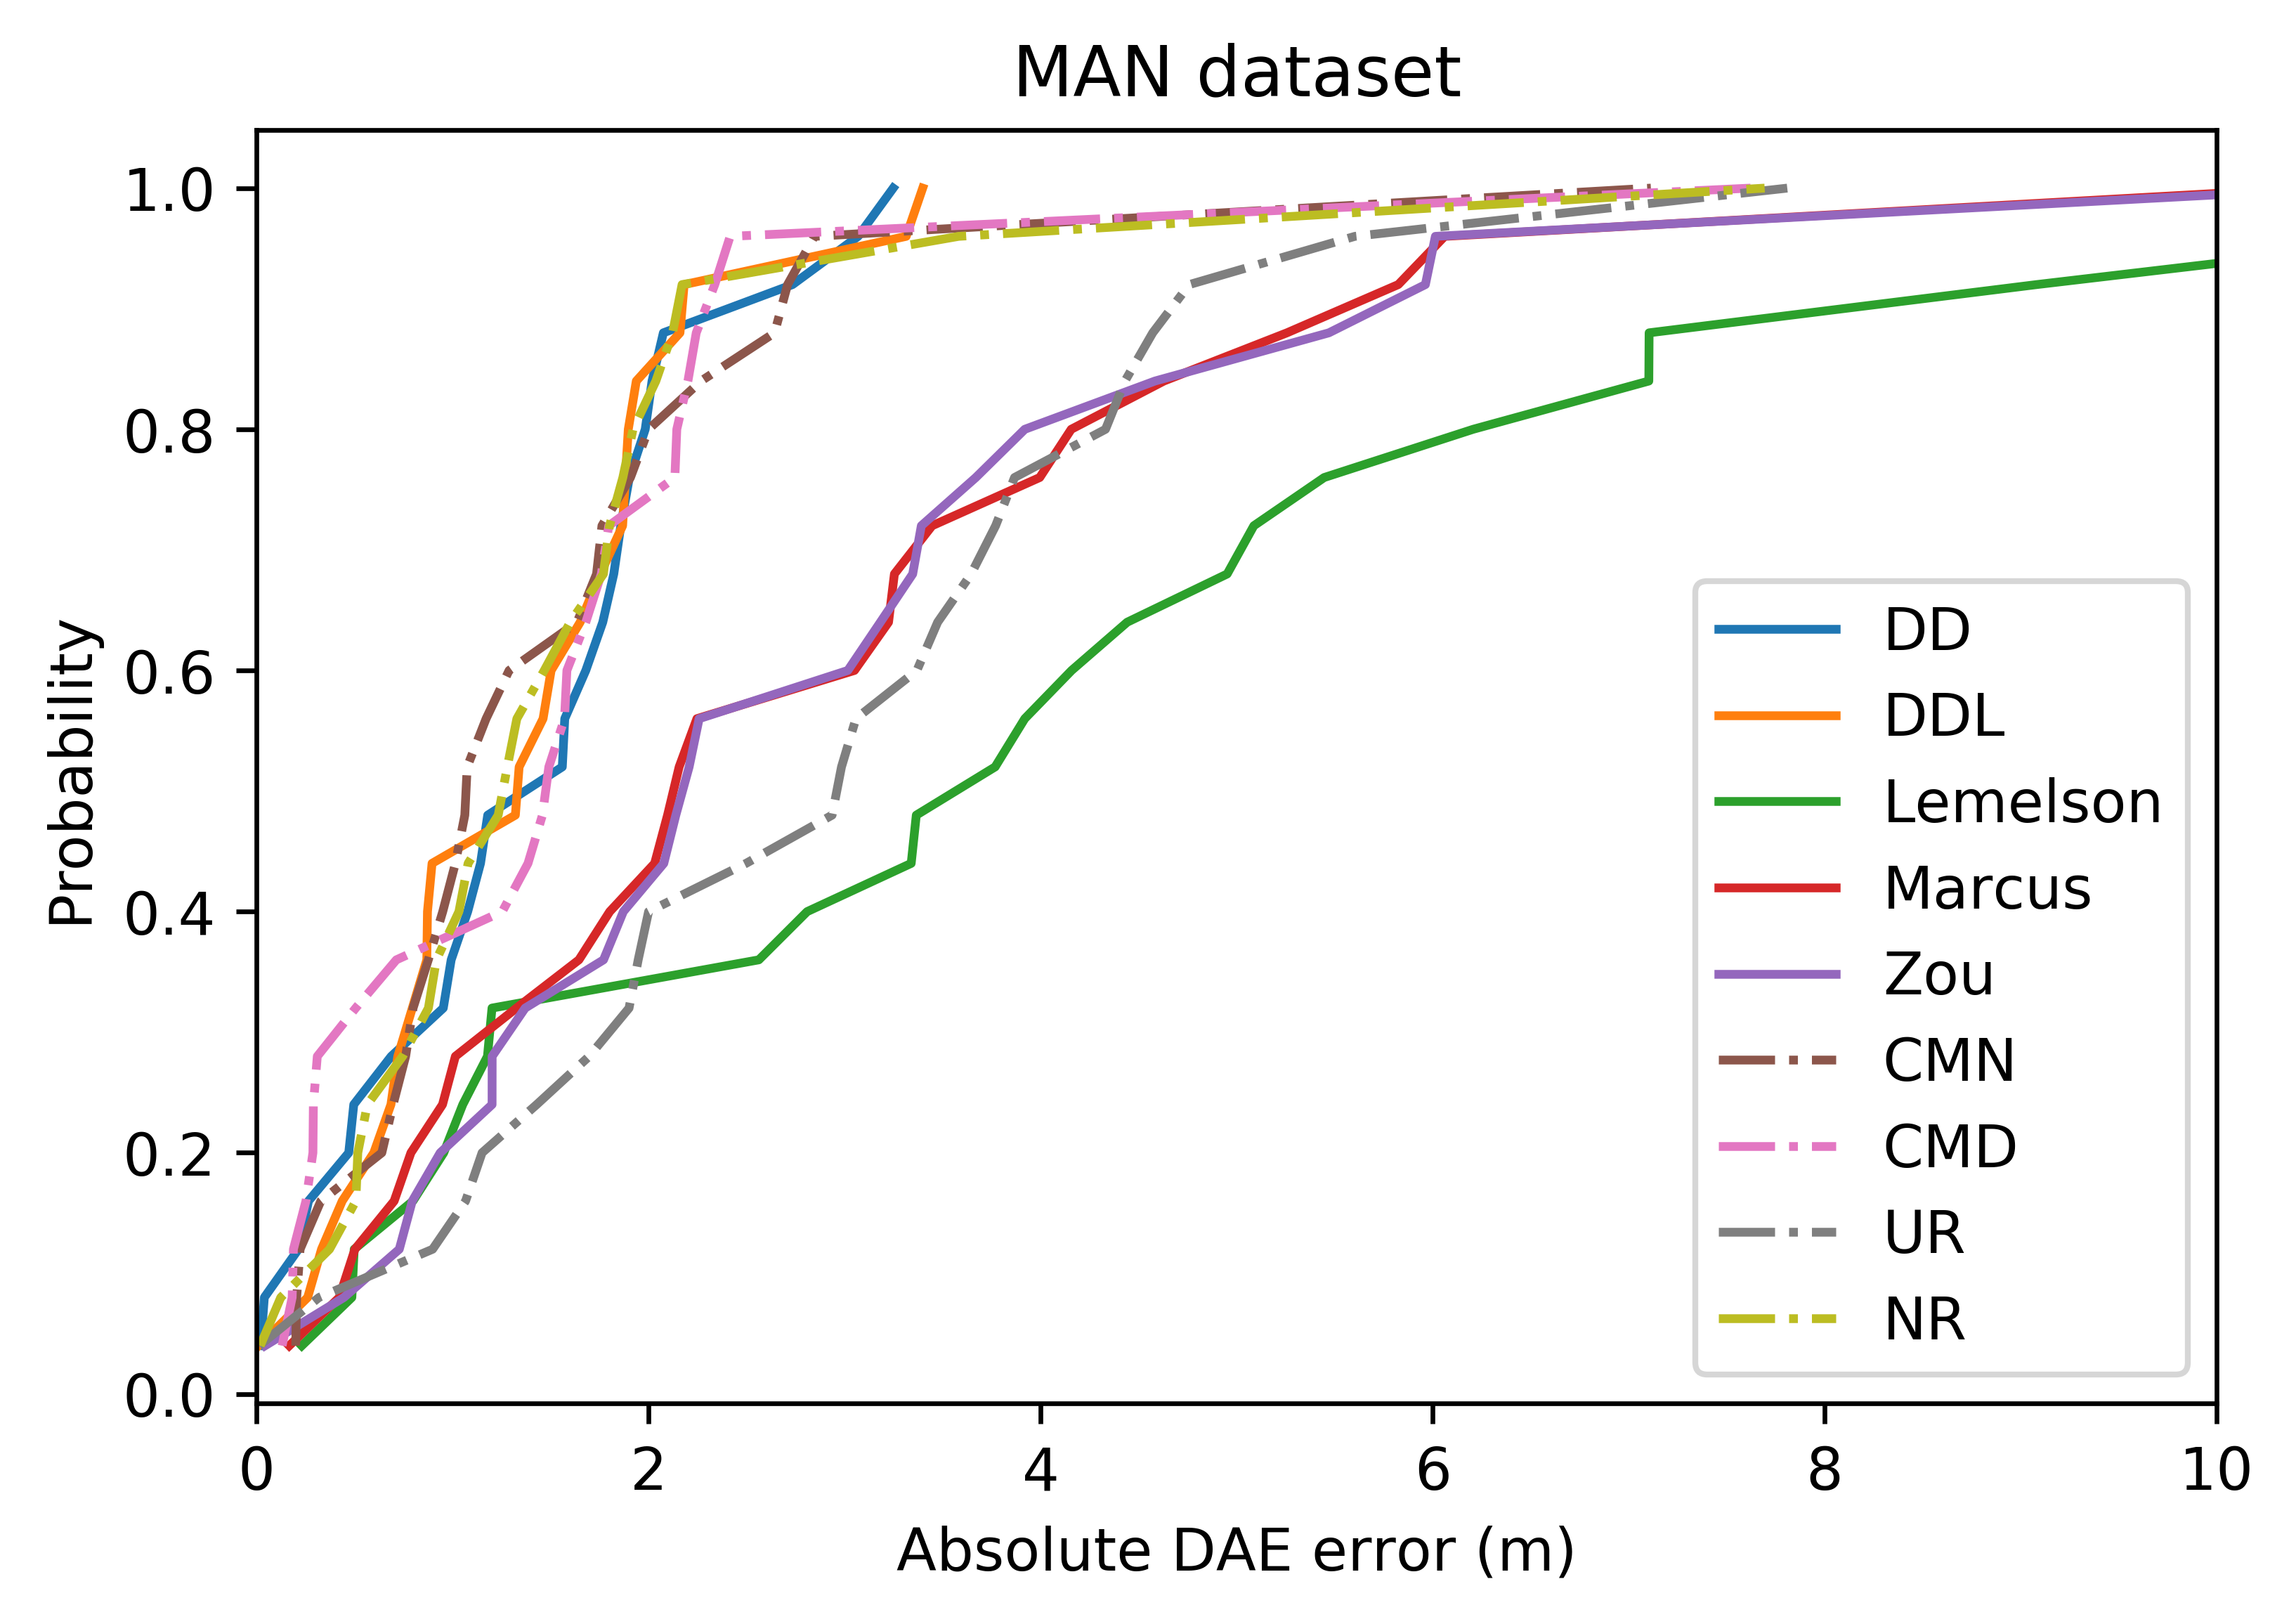

In [20]:
val_length = x_val.shape[0]
prob = []
for i in range(val_length):
    prob.append((i+1)/val_length) # preparing the y axis values
    
fig, ax = plt.subplots(dpi=600)
plt.plot(sorted(DAE_miss_val),prob,color= dict_of_colors['DD'], linestyle = '-',markersize=0.5, label='DD')
plt.plot(sorted(DAE_miss_val_M1),prob,color= dict_of_colors['DDL'], linestyle = '-',markersize=0.5, label='DDL')
plt.plot(sorted(DAE_miss_val_Lemelson),prob,color= dict_of_colors['Lemelson'], linestyle = '-',markersize=0.5, label='Lemelson')
plt.plot(sorted(DAE_miss_val_Marcus),prob,color= dict_of_colors['Marcus'], linestyle = '-',markersize=0.5, label='Marcus')
plt.plot(sorted(DAE_miss_val_Zou),prob,color= dict_of_colors['Zou'], linestyle = '-',markersize=0.5, label='Zou')

# calculating the errors of the baselines
DAE_miss_constant_mean = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_constant_mean))
DAE_miss_constant_median = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_constant_median))
DAE_miss_uniform_random = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_uniform_random))
DAE_miss_normal_random = abs(np.asarray(y_M1_error_val) - np.asarray(DAE_normal_random))

plt.plot(sorted(DAE_miss_constant_mean),prob,color= dict_of_colors['CMN'], linestyle = '-.',markersize=0.5, label='CMN')
plt.plot(sorted(DAE_miss_constant_median),prob,color= dict_of_colors['CMD'], linestyle = '-.',markersize=0.5, label='CMD')
plt.plot(sorted(DAE_miss_uniform_random),prob,color= dict_of_colors['UR'], linestyle = '-.',markersize=0.5, label='UR')
plt.plot(sorted(DAE_miss_normal_random),prob,color= dict_of_colors['NR'], linestyle = '-.',markersize=0.5, label='NR')

if dataset == 'lorawan':
    ax.set( xlim=(0, 800))
elif dataset == 'sigfox':
    ax.set( xlim=(0, 800))     
elif dataset == 'DSI':
    ax.set( xlim=(0, 15))  
elif dataset == 'MAN':
    ax.set( xlim=(0, 10)) 
ax.set_xlabel('Absolute DAE error (m)')
ax.set_ylabel('Probability')
plt.legend(loc='lower right')

if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/CDF_' + dataset + '.png', dpi = 600)

# Signed error CDF

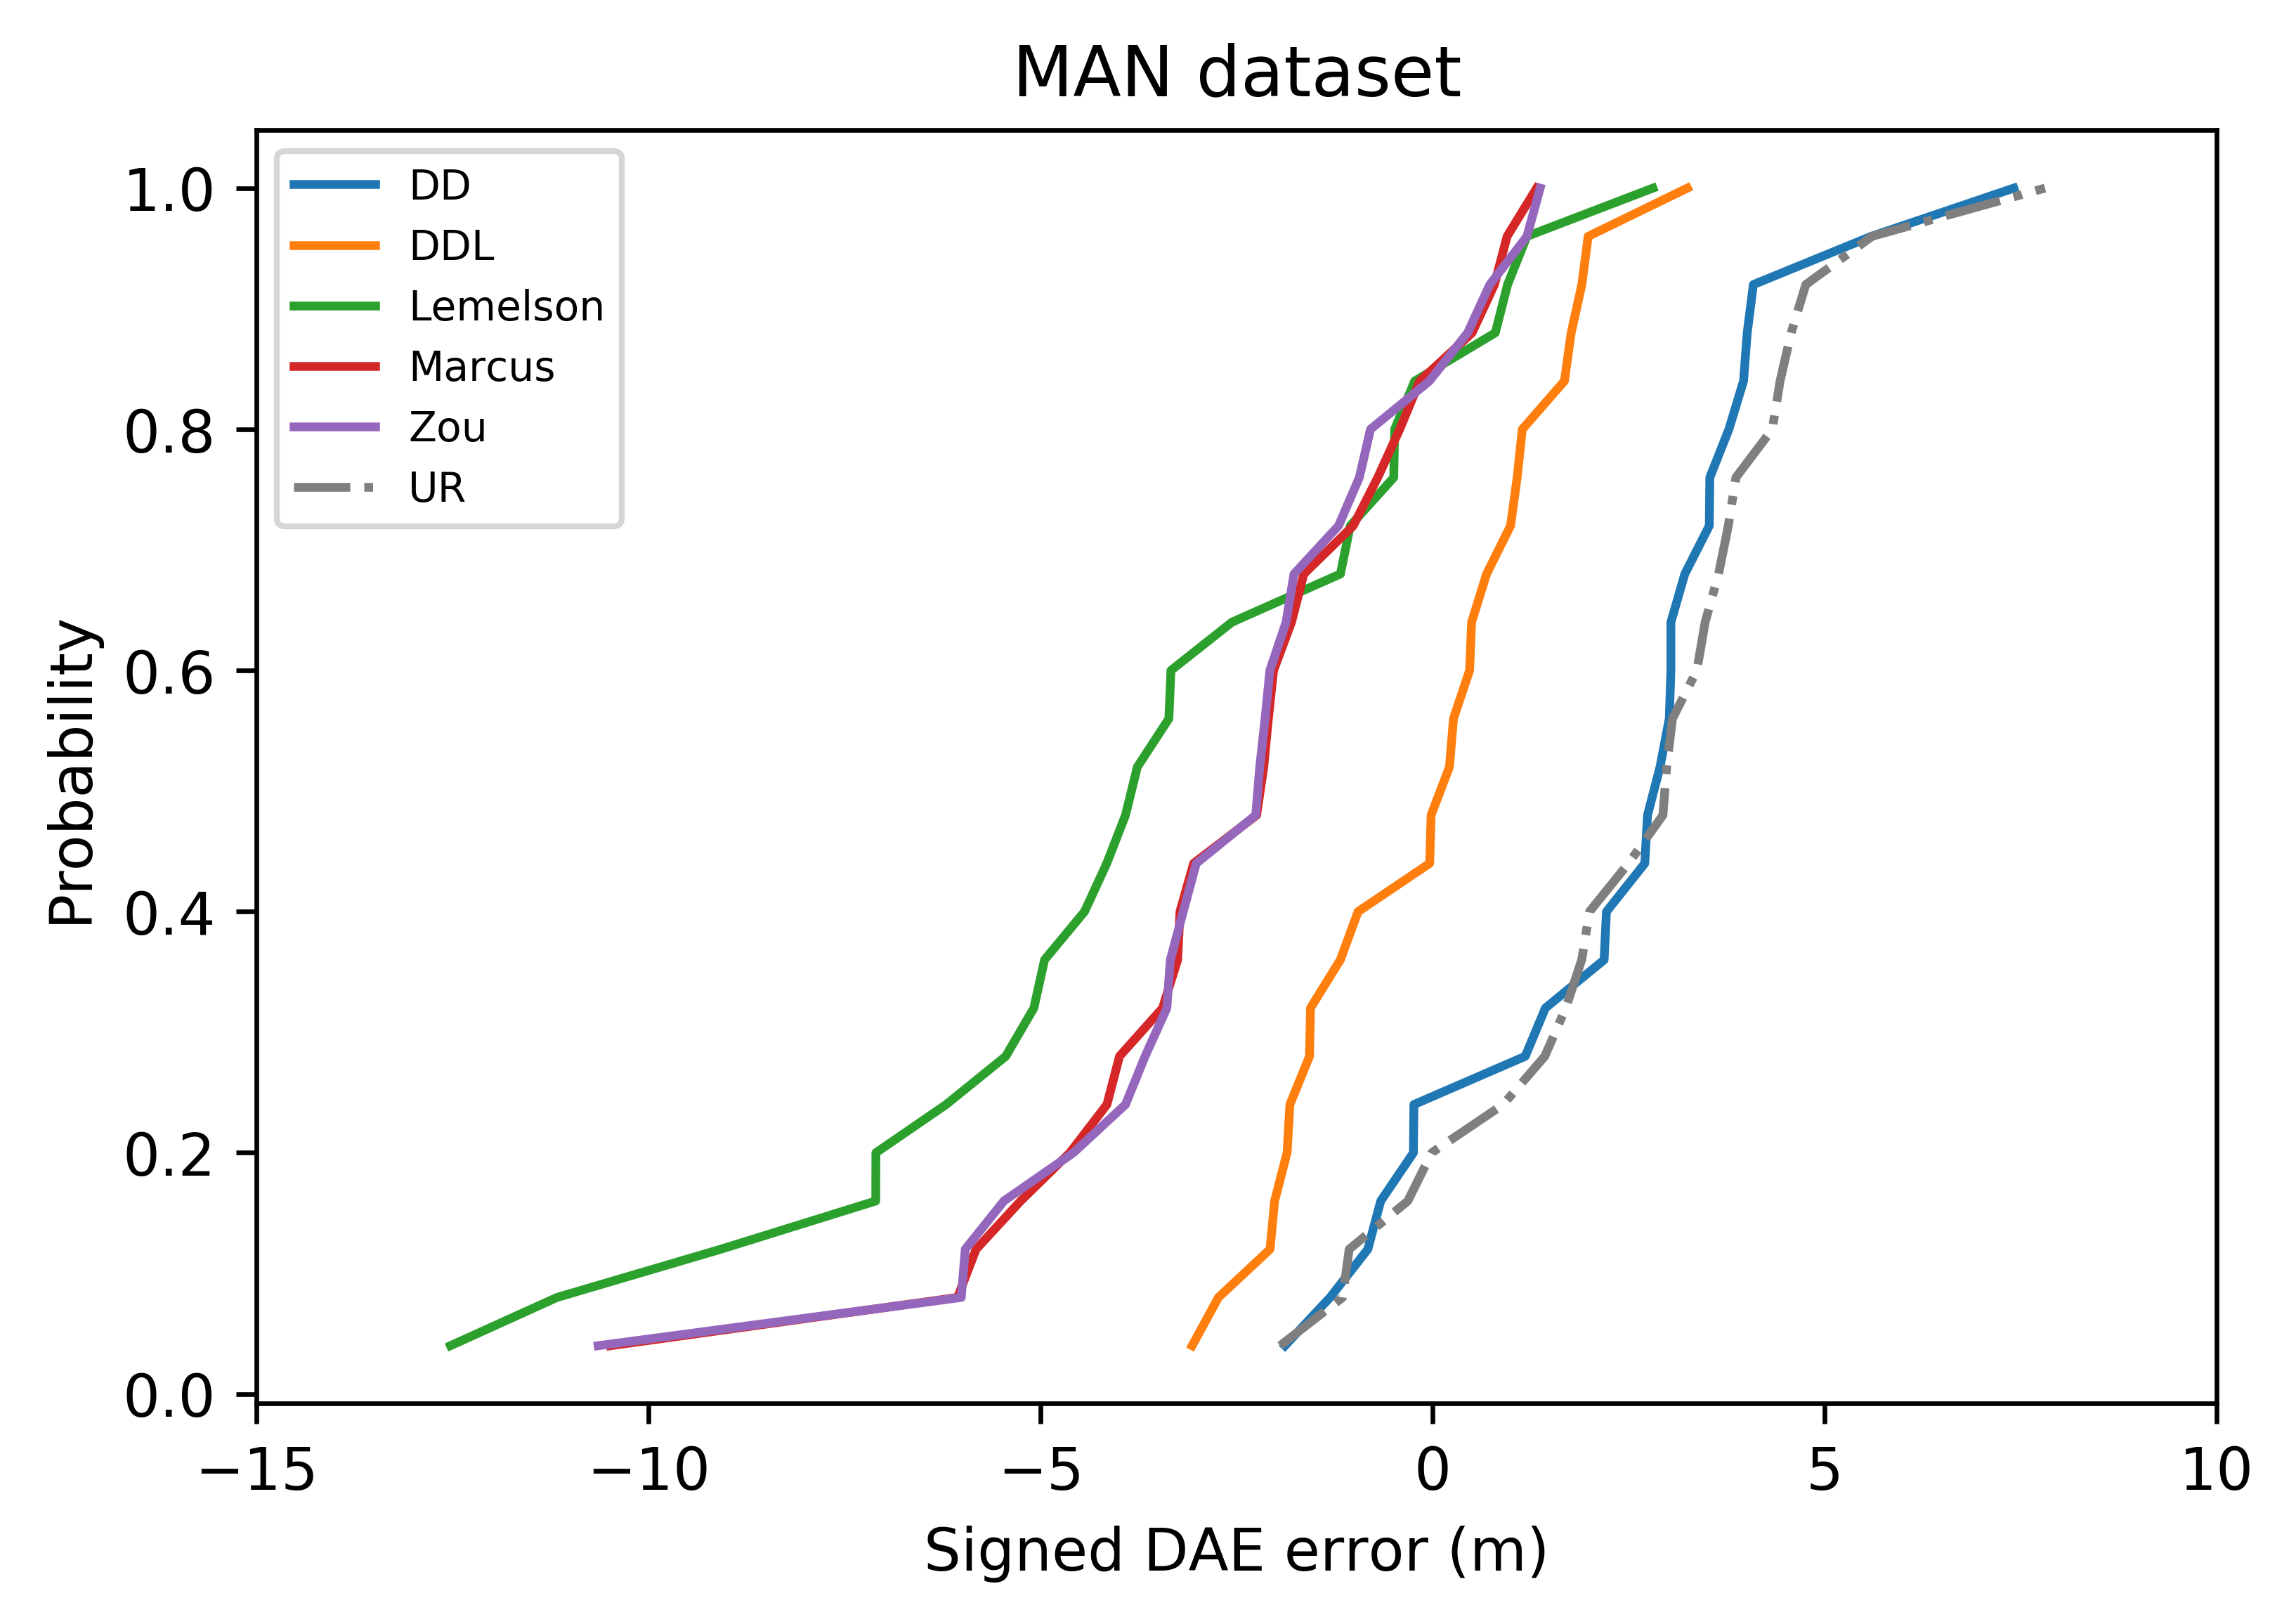

In [21]:
DAE_miss_val_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_in_val.tolist())
DAE_miss_val_M1_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_miss_val_M1.tolist())
DAE_miss_val_Lemelson_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_val_Lemelson)
DAE_miss_val_Marcus_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_val_Marcus)
DAE_miss_val_Zou_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_val_Zou)

# calculating the errors of the baselines
DAE_miss_val_constant_mean_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_constant_mean)
DAE_miss_val_constant_median_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_constant_median)
DAE_miss_val_uniform_random_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_uniform_random)
DAE_miss_val_normal_random_signed = np.asarray(y_M1_error_val) - np.asarray(DAE_normal_random)

fig, ax = plt.subplots(dpi=600)
plt.plot(sorted(DAE_miss_val_M1_signed),prob,color= dict_of_colors['DD'], linestyle = '-',markersize=0.5, label='DD')
plt.plot(sorted(DAE_miss_val_signed),prob,color= dict_of_colors['DDL'], linestyle = '-',markersize=0.5, label='DDL')
plt.plot(sorted(DAE_miss_val_Lemelson_signed),prob,color= dict_of_colors['Lemelson'], linestyle = '-',markersize=0.5, label='Lemelson')
plt.plot(sorted(DAE_miss_val_Marcus_signed),prob,color= dict_of_colors['Marcus'], linestyle = '-',markersize=0.5, label='Marcus')
plt.plot(sorted(DAE_miss_val_Zou_signed),prob,color= dict_of_colors['Zou'], linestyle = '-',markersize=0.5, label='Zou')

####### Selecting to plot only one baseline, for visual clarity
# plt.plot(sorted(DAE_miss_val_constant_mean_signed),prob,color= dict_of_colors['CMN'], linestyle = '-.',markersize=0.5, label='CMN')
# plt.plot(sorted(DAE_miss_val_constant_median_signed),prob,color= dict_of_colors['CMD'], linestyle = '-.',markersize=0.5, label='CMD')
plt.plot(sorted(DAE_miss_val_uniform_random_signed),prob,color= dict_of_colors['UR'], linestyle = '-.',markersize=0.5, label='UR')
# plt.plot(sorted(DAE_miss_val_normal_random_signed),prob,color= dict_of_colors['NR'], linestyle = '-.',markersize=0.5, label='NR')


if dataset == 'lorawan':
    ax.set(xlim=(-2000,2000))
    plt.legend(loc='lower right', prop={'size': 7})
elif dataset == 'sigfox':
    ax.set(xlim=(-2000,2000))    
    plt.legend(loc='lower right') 
elif dataset == 'DSI':
    ax.set(xlim=(-15,15))
    plt.legend(loc='upper left', prop={'size': 7})
elif dataset == 'MAN':
    ax.set(xlim=(-15,10)) 
    plt.legend(loc='upper left', prop={'size': 7})

ax.set_ylabel('Probability')
ax.set_xlabel('Signed DAE error (m)')
if dataset == "lorawan":
    plt.title("LoRaWAN dataset")
elif dataset == "sigfox":
    plt.title("Sigfox dataset")
else:
    plt.title(dataset + " dataset")
plt.savefig('results/' + dataset + '/signed_error_' + dataset + '.png', dpi = 600, bbox_inches= 'tight')